In [65]:
# Rates plot

In [45]:
from utils import config, parse_midas_data, sample_utils as su, temporal_changes_utils, stats_utils, midas_db_utils, parse_patric
from collections import defaultdict
import numpy as np
from numpy.random import binomial as sample_binomial
import math, pickle, sys, random
from math import log10,ceil,log,exp

import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.ticker
from matplotlib.patches import Patch
from matplotlib import rcParams
from matplotlib import gridspec
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

# Plot directory
plot_dir = "%s/" % (config.analysis_directory)

# Species list
good_species_list = parse_midas_data.load_pickled_good_species_list()

# Sample-subject-order-cohort maps
sys.stderr.write("Loading sample metadata...\n")
subject_sample_map = su.parse_subject_sample_map()
sample_order_map = su.parse_sample_order_map()
sample_subject_map = su.parse_sample_subject_map()
sample_cohort_map = su.parse_sample_cohort_map()
same_mi_pair_dict = su.get_same_mi_pair_dict(subject_sample_map)
sys.stderr.write("Done!\n")

# Cohorts
cohorts = ['backhed', 'ferretti', 'yassour', 'shao', 'hmp']
mi_cohorts = ['backhed', 'ferretti', 'yassour', 'shao']

# Samples for each cohort
samples = {cohort: su.get_sample_names(cohort) for cohort in cohorts}
hmp_samples = su.get_sample_names('hmp')
mother_samples = su.get_sample_names('mother')
infant_samples = su.get_sample_names('infant')
olm_samples = su.get_sample_names('olm')
infant_samples = [sample for sample in infant_samples if sample not in olm_samples] # Exclude Olm
mother_samples = [sample for sample in mother_samples if sample not in olm_samples] # Exclude Olm
mi_samples = [sample for sample in (mother_samples + infant_samples) if sample not in olm_samples] # Exclude Olm

# Sample-timepoint map
mi_sample_day_dict = su.get_mi_sample_day_dict(exclude_cohorts=['olm'])
mi_tp_sample_dict = su.get_mi_tp_sample_dict(exclude_cohorts=['olm']) # no binning
mi_tp_sample_dict_binned, mi_tp_binned_labels = su.get_mi_tp_sample_dict(exclude_cohorts=['olm'], binned=True)

# Narrow down samples to no Olm, and mother only at delivery
infant_samples = [sample for sample in infant_samples if sample not in olm_samples]
mother_samples = [sample for sample in mother_samples if (mi_sample_day_dict[sample] < 7 and mi_sample_day_dict[sample] > -7)]
mi_samples = [sample for sample in (mother_samples + infant_samples) if sample not in olm_samples]

# Sample identity wrapper functions
is_infant = lambda sample: sample in infant_samples
is_mother = lambda sample: sample in mother_samples
is_adult = lambda sample: sample in hmp_samples

Loading sample metadata...
Done!


In [2]:
# ======================================================================
# Load pickled data
# ======================================================================

# Parameters
sweep_type = 'full'
pp_prev_cohort = 'all'
min_coverage = 0

ddir = config.data_directory
pdir = "%s/pickles/cov%i_prev_%s/" % (ddir, min_coverage, pp_prev_cohort)

snp_changes = pickle.load(open('%s/big_snp_changes_%s.pkl' % (pdir, sweep_type), 'rb'))
gene_changes = pickle.load(open('%s/big_gene_changes_%s.pkl' % (pdir, sweep_type), 'rb'))
snp_change_freqs = pickle.load(open('%s/snp_change_freqs_%s.pkl' % (pdir, sweep_type), 'rb'))
snp_change_null_freqs = pickle.load(open('%s/snp_change_null_freqs_%s.pkl' % (pdir, sweep_type), 'rb'))
gene_gain_freqs = pickle.load(open('%s/gene_gain_freqs_%s.pkl' % (pdir, sweep_type), 'rb'))
gene_loss_freqs = pickle.load(open('%s/gene_loss_freqs_%s.pkl' % (pdir, sweep_type), 'rb'))
gene_loss_null_freqs = pickle.load(open('%s/gene_loss_null_freqs_%s.pkl' % (pdir, sweep_type), 'rb'))
between_snp_change_counts = pickle.load(open('%s/between_snp_change_counts_%s.pkl' % (pdir, sweep_type), 'rb'))
between_gene_change_counts = pickle.load(open('%s/between_gene_change_counts_%s.pkl' % (pdir, sweep_type), 'rb'))

# nonconsecutive
pdir = "%s/pickles/cov%i_prev_%s/nonconsecutive/" % (ddir, min_coverage, pp_prev_cohort)

dnds_info = pickle.load(open('%s/dnds_info.pkl' % (pdir), 'rb'))
snp_change_freqs_with_opps = pickle.load(open('%s/snp_change_freqs_with_opps_full.pkl' % (pdir), 'rb'))

In [3]:
# Calculate number of days for a sample pair (mother-infant)
def mi_sample_pair_to_days(sample1, sample2):
    days = mi_sample_day_dict[sample2] - mi_sample_day_dict[sample1]
    return days

# Rough approximation of HMP time intervals
def adult_sample_pair_to_days(sample1, sample2):
    order1 = sample_order_map[sample1][1]
    order2 = sample_order_map[sample2][1]
    return (order2 - order1)*183

# Unify days calculation (assume if not AA, then must be mother-infant)
def sample_pair_to_days(sample1, sample2):
    if is_adult(sample1) and is_adult(sample2):
        return adult_sample_pair_to_days(sample1, sample2)
    else:
        return mi_sample_pair_to_days(sample1, sample2)

In [4]:
# Define function for bootstrapping

def bootstrapped_agg_from_list_dict(listdict, aggregator_fn, num_bootstraps=20, n=50):
    bootstrapped_agg_dict = defaultdict(list)
    for key in listdict:
        all_items = listdict[key]
        for _ in np.arange(num_bootstraps):
            bootstrap = [random.choice(all_items) for i in np.arange(n)]
            bootstrapped_agg_dict[key].append(aggregator_fn(bootstrap))
    return bootstrapped_agg_dict

In [5]:
# Define function needed for survival curve plots

def calculate_unnormalized_survival_from_vector(counts):
    counts = sorted(counts)
    xs = [0]
    ns = [len(counts)]
    ns_cur = len(counts)
    min_count = -1
    for count in counts:
        if count > min_count:
            ns.append(ns_cur) # Number of elements greater or equal
            xs.append(count)
            min_count = count
        ns_cur -= 1
    xs.append(xs[len(xs)-1]+1)
    ns.append(0)
    return xs, np.array(ns)

In [6]:
# Calculating rate from tuples
def get_rate_from_tuples(sweep_day_tuple_list):
    total_sweeps = 0
    total_days = 0
    for num_sweeps, days in sweep_day_tuple_list:
        total_sweeps += num_sweeps
        total_days += days
    rate = float(total_sweeps)/total_days
    return rate


In [7]:
# Custom sample pair cohorts [not just sample!]
# Alternate version where a sample pair may be assigned multiple cohorts

# custom_cohort_tests: dictionary where keys are cohort names and values are 
# boolean functions taking in sample_i, sample_j as arguments

def custom_cohorts_of_sample_pair(custom_cohort_tests, sample_i, sample_j, species='dummy'):
    my_cohorts = set()
    for cohort in custom_cohort_tests:
        if custom_cohort_tests[cohort](sample_i, sample_j, species):
            my_cohorts.add(cohort)
    return my_cohorts

In [74]:
# Establish custom cohorts to be used for all three rates plots

custom_cohort_tests = {}

custom_cohort_tests['Mother-Infant(all)']        = lambda s1, s2, sp: (is_mother(s1) and is_infant(s2))

custom_cohort_tests['Mother-Infant']             = lambda s1, s2, sp: ((is_mother(s1) and is_infant(s2)) 
                                                        and mi_sample_day_dict[s1] >= 0 
                                                        and mi_sample_day_dict[s2] <= 7)

custom_cohort_tests['Infant-Infant']        = lambda s1, s2, sp: (is_infant(s1) and is_infant(s2))

custom_cohort_tests['Day 0-Week 1']   = lambda s1, s2, sp: ((is_infant(s1) and is_infant(s2))
                                                        and mi_sample_day_dict[s1] >= 0
                                                        and mi_sample_day_dict[s2] <= 7)

custom_cohort_tests['Week 1-Month 1'] = lambda s1, s2, sp: ((is_infant(s1) and is_infant(s2)) 
                                                        and mi_sample_day_dict[s1] >= 7
                                                        and mi_sample_day_dict[s2] <= 31)

custom_cohort_tests['Month 1-Year 1'] = lambda s1, s2, sp: ((is_infant(s1) and is_infant(s2)) 
                                                        and mi_sample_day_dict[s1] >= 31 
                                                        and mi_sample_day_dict[s2] <= 367)

custom_cohort_tests['Adult-Adult']             = lambda s1, s2, sp: (is_adult(s1) and is_adult(s2))

custom_cohort_tests['II-1mon'] = lambda s1, s2, sp: ((is_infant(s1) and is_infant(s2))
                                                     and (sample_pair_to_days(s1, s2) < 32))

custom_cohort_tests['II-1yr'] = lambda s1, s2, sp: ((is_infant(s1) and is_infant(s2))
                                                    and (sample_pair_to_days(s1, s2) > 90))

custom_cohort_tests['6mon duration infant'] = lambda s1, s2, sp: ((is_infant(s1) and is_infant(s2)) 
                                                              and (sample_pair_to_days(s1, s2) >= 175) 
                                                              and (sample_pair_to_days(s1, s2) <= 191))

custom_cohort_tests['6mon duration adult'] = lambda s1, s2, sp: ((is_adult(s1) and is_adult(s2)) 
                                                              and (sample_pair_to_days(s1, s2) >= 175) 
                                                              and (sample_pair_to_days(s1, s2) <= 191))

# 6 months +/- 8 days: if days >= 175 and days <= 191

custom_cohort_tests['4-8mon duration infant'] = lambda s1, s2, sp: ((is_infant(s1) and is_infant(s2)) 
                                                              and (sample_pair_to_days(s1, s2) >= (4*30.5)) 
                                                              and (sample_pair_to_days(s1, s2) <= (8*30.5)))

custom_cohort_tests['4-8mon duration adult'] = lambda s1, s2, sp: ((is_adult(s1) and is_adult(s2)) 
                                                              and (sample_pair_to_days(s1, s2) >= (4*30.5)) 
                                                              and (sample_pair_to_days(s1, s2) <= (8*30.5)))

In [70]:
# species -> mother_sample -> infant_sample -> # days of infant_sample
# mother timepoint at delivery (-1 to 7 days)
mi_dict = {species: defaultdict(dict) for species in gene_gain_freqs}

for species in snp_changes:
    for sample_i, sample_j in snp_changes[species]:
        
        # MI: restrict to earliest mother-infant pair per host
        if 'Mother-Infant(all)' in custom_cohorts_of_sample_pair(custom_cohort_tests, sample_i, sample_j):
            mother_days = mi_sample_day_dict[sample_i]
            if mother_days >= -1 and mother_days <= 7:
                mi_dict[species][sample_i][sample_j] = mi_sample_day_dict[sample_j]

# species -> mother_sample -> earliest infant sample
mi_earliest_infant_sample_dict = defaultdict(dict)

# Distribution of which day the earliest infant tp occurs at
# Hopefully nothing too late
earliest_infant_days = []

for species in mi_dict:
    for mother_sample in mi_dict[species]:
        ordered_infant_days = sorted(mi_dict[species][mother_sample].items(), key=lambda x: x[1])
        infant_sample, days = ordered_infant_days[0]
        mi_earliest_infant_sample_dict[species][mother_sample] = infant_sample
        earliest_infant_days.append(days)

In [71]:
print(sorted(earliest_infant_days))

[0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 11, 14, 14, 14, 14, 21, 21, 30, 30, 30, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 211, 221, 266, 271, 311, 311, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 383]


In [72]:
# Add one more category
custom_cohort_tests['Mother-Infant(earliest)']  = lambda s1, s2, sp: ((is_mother(s1) and is_infant(s2) 
                                                                       and (s1 in mi_earliest_infant_sample_dict[sp]) 
                                                                       and (s2 == mi_earliest_infant_sample_dict[sp][s1])))

In [169]:
# Store SNP change information

replacement_time_tups_by_tp_type = defaultdict(list)
all_time_tups_by_tp_type = defaultdict(list)
count_time_tups_by_tp_type = defaultdict(list)

for species in snp_changes:
    for s1, s2 in snp_changes[species]:
        
        val = snp_changes[species][(s1, s2)]        
        custom_cohorts = custom_cohorts_of_sample_pair(custom_cohort_tests, s1, s2, species)
        days = sample_pair_to_days(s1, s2)
        
        # Skip negative days for now (seems to be either Yassour 3rd mom tp, Ferretti reverse IM)
        if days < 0:
            continue
        
        # Arbitrarily set mother 0 - infant 0 as 1 day
        if is_mother(s1) and mi_sample_day_dict[s1] == 0 and is_infant(s2) and mi_sample_day_dict[s2] == 0:
            days = 1
        
        if isinstance(val, int): # Replacement
            for custom_cohort in custom_cohorts:
                replacement_time_tups_by_tp_type[custom_cohort].append((1, days))
                all_time_tups_by_tp_type[custom_cohort].append((val, days))
        else: # Not replacement (modifications/no change)
            for custom_cohort in custom_cohorts:
                count_time_tups_by_tp_type[custom_cohort].append((len(val), days))
                all_time_tups_by_tp_type[custom_cohort].append((len(val), days))

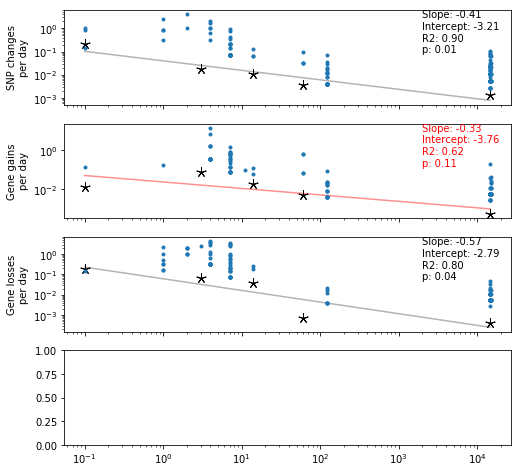

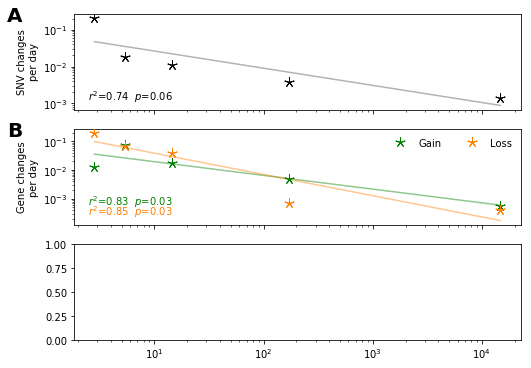

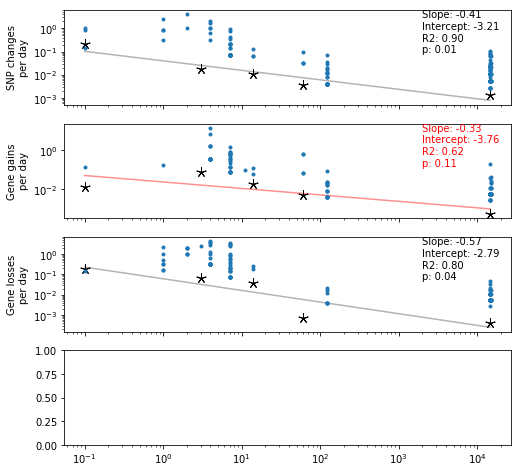

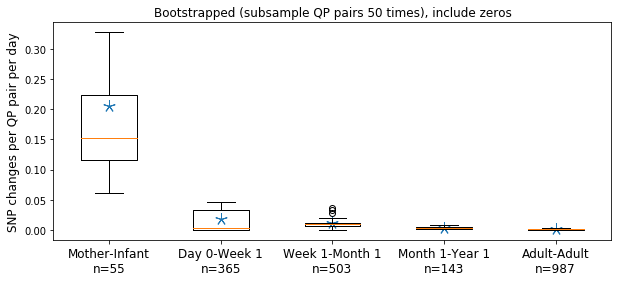

In [170]:
# Subsample QP pairs in a category to n=50 and get #sweeps/day, bootstrap 20 times
bootstrapped_rates_by_tp_type = bootstrapped_agg_from_list_dict(count_time_tups_by_tp_type, get_rate_from_tuples)

# SNP change rates boxplot
fig, ax = plt.subplots(figsize=(10,4))

tp_types = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'Adult-Adult']
annotations = [] # These are the true "average" rates per category
tp_type_labels = [] # These are used as x-axis labels

bootstrapped_rates = [bootstrapped_rates_by_tp_type[tp_type] for tp_type in tp_types]
for tp_type in tp_types:
    snp_count, total_days = (0,0)
    for count, days in count_time_tups_by_tp_type[tp_type]:
        snp_count += count
        total_days += days
    annotations.append(float(snp_count)/total_days)
    tp_type_labels.append('%s\nn=%i' % (tp_type, len(count_time_tups_by_tp_type[tp_type])))

ax.plot(np.arange(1, 1+len(annotations)), annotations, marker=(5, 2), linestyle='None', markersize=12)
ax.boxplot(bootstrapped_rates)
# ax.set_ylim(0, 0.14)
ax.set_xticklabels(tp_type_labels, fontsize=12)
ax.set_ylabel("SNP changes per QP pair per day", fontsize=12)
ax.set_title("Bootstrapped (subsample QP pairs 50 times), include zeros")

plt.show()

In [171]:
# Store for later use
snp_change_rates = bootstrapped_rates
snp_change_rate_annotations = annotations
snp_change_rate_tp_type_labels = tp_type_labels

In [134]:
# Get statistics for paper
print(snp_change_rate_annotations)

[0.20512820512820512, 0.01834862385321101, 0.011333643844123583, 0.0037812413538688555, 0.0014128695796713]


T: 11.02	p: 2.121E-13


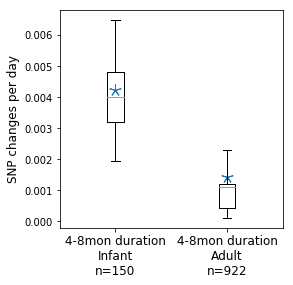

In [138]:
# Matched
# SNP change rates boxplot
fig, ax = plt.subplots(figsize=(4,4))

tp_types = ['4-8mon duration infant', '4-8mon duration adult']
labels = ['4-8mon duration\nInfant', '4-8mon duration\nAdult']
annotations = [] # These are the true "average" rates per category
tp_type_labels = [] # These are used as x-axis labels

bootstrapped_rates = [bootstrapped_rates_by_tp_type[tp_type] for tp_type in tp_types]
for tp_type, label in zip(tp_types, labels):
    snp_count, total_days = (0,0)
    for count, days in count_time_tups_by_tp_type[tp_type]:
        snp_count += count
        total_days += days
    annotations.append(float(snp_count)/total_days)
    tp_type_labels.append('%s\nn=%i' % (label, len(count_time_tups_by_tp_type[tp_type])))

ax.plot(np.arange(1, 1+len(annotations)), annotations, marker=(5, 2), linestyle='None', markersize=12)
ax.boxplot(bootstrapped_rates)
# ax.set_ylim(0, 0.14)
ax.set_xticklabels(tp_type_labels, fontsize=12)
ax.set_ylabel("SNP changes per day", fontsize=12)
# ax.set_title("Bootstrapped (subsample QP pairs 50 times), include zeros")

t, p = stats.ttest_ind(bootstrapped_rates[0], bootstrapped_rates[1])
print("T: %.02f\tp: %.3E" % (t, p))
plt.show()

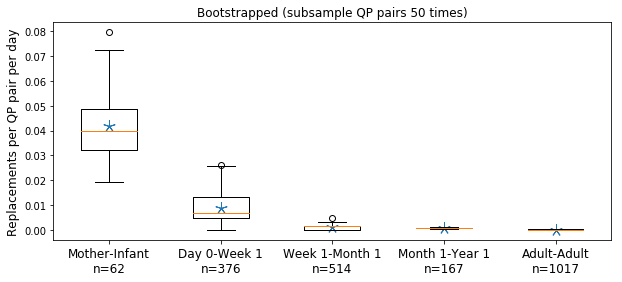

In [172]:
# Calculating replacement rate from all tuples
def get_replacement_rate_from_tuples(snp_diffs_day_tuple_list):
    total_replacements = 0
    total_days = 0
    for num_snp_changes, days in snp_diffs_day_tuple_list:
        if num_snp_changes >= 500:
            total_replacements += 1
        total_days += days
    rate = (float(total_replacements)/total_days)
    return rate

# Subsample QP pairs in a category to n=50 and get #sweeps/day, bootstrap 20 times
bootstrapped_rates_by_tp_type = bootstrapped_agg_from_list_dict(all_time_tups_by_tp_type, get_replacement_rate_from_tuples)

# Replacement rates boxplot
fig, ax = plt.subplots(figsize=(10,4))

tp_types = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'Adult-Adult']
annotations = [] # These are the true "average" rates per category
tp_type_labels = [] # These are used as x-axis labels

bootstrapped_rates = [bootstrapped_rates_by_tp_type[tp_type] for tp_type in tp_types]
for tp_type in tp_types:
    replacement_count, total_days = (0,0)
    for num_snp_changes, days in all_time_tups_by_tp_type[tp_type]:
        if num_snp_changes >= 500:
            replacement_count += 1
        total_days += days
    annotations.append(float(replacement_count)/total_days)
    tp_type_labels.append('%s\nn=%i' % (tp_type, len(all_time_tups_by_tp_type[tp_type])))

ax.plot(np.arange(1, 1+len(annotations)), annotations, marker=(5, 2), linestyle='None', markersize=12)
ax.boxplot(bootstrapped_rates)
ax.set_xticklabels(tp_type_labels, fontsize=12)
ax.set_ylabel("Replacements per QP pair per day", fontsize=12)
ax.set_title("Bootstrapped (subsample QP pairs 50 times)")

plt.show()

# fig.savefig('%s/replacement_rates_by_tp_type_overall_with_zeros_labelled.pdf' % plot_dir, bbox_inches='tight')

In [173]:
# store for later use
replacement_rates = bootstrapped_rates
replacement_rate_annotations = annotations
replacement_rate_tp_type_labels = tp_type_labels

In [133]:
# Get statistics for paper
print(replacement_rate_annotations)

[0.041666666666666664, 0.008857395925597875, 0.0013646702047005307, 0.0008113291045876973, 0.00012590969756490645]


T: 12.32	p: 7.712E-15


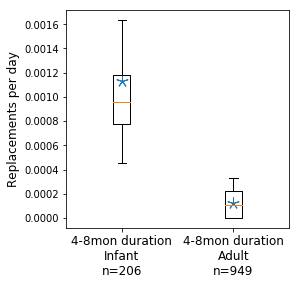

In [141]:
# Matched
# replacement rates boxplot
fig, ax = plt.subplots(figsize=(4,4))

tp_types = ['4-8mon duration infant', '4-8mon duration adult']
labels = ['4-8mon duration\nInfant', '4-8mon duration\nAdult']
annotations = [] # These are the true "average" rates per category
tp_type_labels = [] # These are used as x-axis labels

bootstrapped_rates = [bootstrapped_rates_by_tp_type[tp_type] for tp_type in tp_types]
for tp_type, label in zip(tp_types, labels):
    replacement_count, total_days = (0,0)
    for num_snp_changes, days in all_time_tups_by_tp_type[tp_type]:
        if num_snp_changes >= 500:
            replacement_count += 1
        total_days += days
    annotations.append(float(replacement_count)/total_days)
    tp_type_labels.append('%s\nn=%i' % (label, len(all_time_tups_by_tp_type[tp_type])))

ax.plot(np.arange(1, 1+len(annotations)), annotations, marker=(5, 2), linestyle='None', markersize=12)
ax.boxplot(bootstrapped_rates)
# ax.set_ylim(0, 0.14)
ax.set_xticklabels(tp_type_labels, fontsize=12)
ax.set_ylabel("Replacements per day", fontsize=12)
# ax.set_title("Bootstrapped (subsample QP pairs 50 times), include zeros")

t, p = stats.ttest_ind(bootstrapped_rates[0], bootstrapped_rates[1])
print("T: %.02f\tp: %.3E" % (t, p))
plt.show()

In [174]:
# Store gene change information

gain_tups_by_tp_type = defaultdict(list)
loss_tups_by_tp_type = defaultdict(list)

for species in gene_changes:
    for s1, s2 in gene_changes[species]:
        
        gains, losses = gene_changes[species][(s1, s2)]
        custom_cohorts = custom_cohorts_of_sample_pair(custom_cohort_tests, s1, s2, species)
        days = sample_pair_to_days(s1, s2)
        
        # Skip negative days for now (seems to be either Yassour 3rd mom tp, Ferretti reverse IM)
        if days < 0:
            continue
        
        # Arbitrarily set mother 0 - infant 0 as 1 day
        if is_mother(s1) and mi_sample_day_dict[s1] == 0 and is_infant(s2) and mi_sample_day_dict[s2] == 0:
            days = 1
        
        if isinstance(snp_changes[species][(s1, s2)], int): # Replacement (in terms of SNP changes)
            continue# num_gains, num_losses = gene_changes[species][(s1, s2)]
        else:
            num_gains = len(gene_changes[species][(s1, s2)][0])
            num_losses = len(gene_changes[species][(s1, s2)][1])
        
        # Try excluding the Mother-Infant(wk1) QP pair with unsually high number of losses
        if (num_losses >= 13) and ('Mother-Infant' in custom_cohorts):
            print("Sample pair %s, %s | %s" % (s1, s2, species))
            print("Num losses: %i | Num gains: %i" % (num_losses, num_gains))
            continue
        
        for custom_cohort in custom_cohorts:
            gain_tups_by_tp_type[custom_cohort].append((num_gains, days))
            loss_tups_by_tp_type[custom_cohort].append((num_losses, days))

Sample pair ERR3405407, ERR3405406 | Bacteroides_vulgatus_57955
Num losses: 13 | Num gains: 0


In [60]:
for num_losses, days in loss_tups_by_tp_type['Mother-Infant']:
    if num_losses > 0:
        print((num_losses, days))

(1, 7)
(1, 3)
(1, 6)
(1, 1)
(3, 3)
(2, 1)
(2, 1)
(1, 6)
(1, 3)
(1, 1)
(1, 1)
(2, 1)


In [61]:
for num_gains, days in gain_tups_by_tp_type['Mother-Infant']:
    if num_gains > 0:
        print((num_gains, days))

(1, 7)
(1, 6)


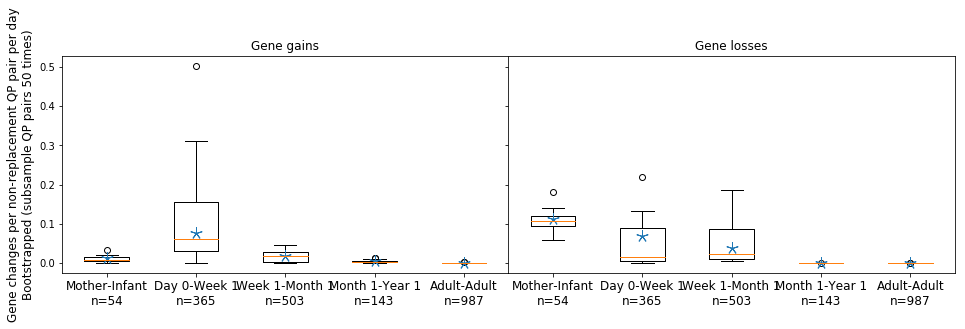

In [175]:
# Calculating gene gain and loss rate from tuples
def get_replacement_rate_from_tuples(snp_diffs_day_tuple_list):
    total_replacements = 0
    total_days = 0
    for num_snp_changes, days in snp_diffs_day_tuple_list:
        if num_snp_changes >= 500:
            total_replacements += 1
        total_days += days
    rate = (float(total_replacements)/total_days)
    return rate

# Subsample QP pairs in a category to n=50 and get #sweeps/day, bootstrap 20 times
bootstrapped_gain_rates_by_tp_type = bootstrapped_agg_from_list_dict(gain_tups_by_tp_type, get_rate_from_tuples)
bootstrapped_loss_rates_by_tp_type = bootstrapped_agg_from_list_dict(loss_tups_by_tp_type, get_rate_from_tuples)

# Gene gain/loss rates boxplot
fig, ax = plt.subplots(1, 2, figsize=(16,4), sharey=True)

tp_types = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'Adult-Adult']

# These are the true "average" rates per category
gain_annotations = []; loss_annotations = [] 

# These are used as x-axis labels
gain_tp_type_labels = []; loss_tp_type_labels = []

bootstrapped_gain_rates = [bootstrapped_gain_rates_by_tp_type[tt] for tt in tp_types]
bootstrapped_loss_rates = [bootstrapped_loss_rates_by_tp_type[tt] for tt in tp_types]

for tp_type in tp_types:
    
    # Store gain info
    gain_count, total_days = (0,0)
    for num_gains, days in gain_tups_by_tp_type[tp_type]:
        gain_count += num_gains; total_days += days    
    gain_annotations.append(float(gain_count)/total_days)
    gain_tp_type_labels.append('%s\nn=%i' % (tp_type, len(gain_tups_by_tp_type[tp_type])))
    
    # Store loss info
    loss_count, total_days = (0,0)
    for num_losss, days in loss_tups_by_tp_type[tp_type]:
        loss_count += num_losss; total_days += days
    loss_annotations.append(float(loss_count)/total_days)
    loss_tp_type_labels.append('%s\nn=%i' % (tp_type, len(loss_tups_by_tp_type[tp_type])))

ax[0].boxplot(bootstrapped_gain_rates)
ax[0].plot(np.arange(1, 1+len(gain_annotations)), gain_annotations, marker=(5, 2), linestyle='None', markersize=12)
ax[0].set_xticklabels(gain_tp_type_labels, fontsize=12)
ax[0].set_ylabel("Gene changes per non-replacement QP pair per day\nBootstrapped (subsample QP pairs 50 times)", fontsize=12)
ax[0].set_title("Gene gains")

ax[1].boxplot(bootstrapped_loss_rates)
ax[1].plot(np.arange(1, 1+len(loss_annotations)), loss_annotations, marker=(5, 2), linestyle='None', markersize=12)
ax[1].set_xticklabels(loss_tp_type_labels, fontsize=12)
ax[1].set_title("Gene losses")

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# fig.savefig('%s/gene_gain_and_loss_rates_by_tp_type_overall_with_zeros_labelled.png' % plot_dir, bbox_inches='tight', dpi=600)

T: 2.93	p: 5.636E-03


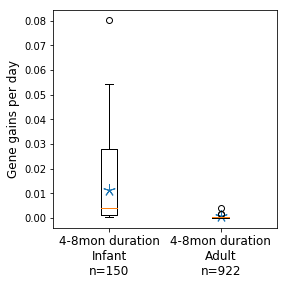

In [145]:
# Matched
# gene gain/loss rate boxplot
fig, ax = plt.subplots(figsize=(4,4))

tp_types = ['4-8mon duration infant', '4-8mon duration adult']
labels = ['4-8mon duration\nInfant', '4-8mon duration\nAdult']
gain_annotations = [] # These are the true "average" rates per category
gain_tp_type_labels = [] # These are used as x-axis labels

bootstrapped_gain_rates = [bootstrapped_gain_rates_by_tp_type[tp_type] for tp_type in tp_types]
for tp_type, label in zip(tp_types, labels):
    gain_count, total_days = (0,0)
    for num_gains, days in gain_tups_by_tp_type[tp_type]:
        gain_count += num_gains; total_days += days
    gain_annotations.append(float(gain_count)/total_days)
    gain_tp_type_labels.append('%s\nn=%i' % (label, len(gain_tups_by_tp_type[tp_type])))

ax.plot(np.arange(1, 1+len(gain_annotations)), gain_annotations, marker=(5, 2), linestyle='None', markersize=12)
ax.boxplot(bootstrapped_gain_rates)
# ax.set_ylim(0, 0.14)
ax.set_xticklabels(gain_tp_type_labels, fontsize=12)
ax.set_ylabel("Gene gains per day", fontsize=12)
# ax.set_title("Bootstrapped (subsample QP pairs 50 times), include zeros")

t, p = stats.ttest_ind(bootstrapped_gain_rates[0], bootstrapped_gain_rates[1])
print("T: %.02f\tp: %.3E" % (t, p))
plt.show()

T: 4.66	p: 3.823E-05


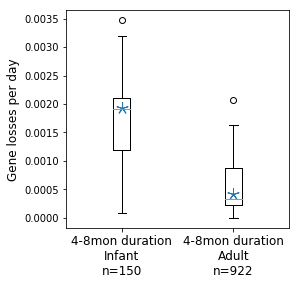

In [146]:
# Matched
# gene gain/loss rate boxplot
fig, ax = plt.subplots(figsize=(4,4))

tp_types = ['4-8mon duration infant', '4-8mon duration adult']
labels = ['4-8mon duration\nInfant', '4-8mon duration\nAdult']
loss_annotations = [] # These are the true "average" rates per category
loss_tp_type_labels = [] # These are used as x-axis labels

bootstrapped_loss_rates = [bootstrapped_loss_rates_by_tp_type[tp_type] for tp_type in tp_types]
for tp_type, label in zip(tp_types, labels):
    loss_count, total_days = (0,0)
    for num_losss, days in loss_tups_by_tp_type[tp_type]:
        loss_count += num_losss; total_days += days
    loss_annotations.append(float(loss_count)/total_days)
    loss_tp_type_labels.append('%s\nn=%i' % (label, len(loss_tups_by_tp_type[tp_type])))

ax.plot(np.arange(1, 1+len(loss_annotations)), loss_annotations, marker=(5, 2), linestyle='None', markersize=12)
ax.boxplot(bootstrapped_loss_rates)
# ax.set_ylim(0, 0.14)
ax.set_xticklabels(loss_tp_type_labels, fontsize=12)
ax.set_ylabel("Gene losses per day", fontsize=12)
# ax.set_title("Bootstrapped (subsample QP pairs 50 times), include zeros")

t, p = stats.ttest_ind(bootstrapped_loss_rates[0], bootstrapped_loss_rates[1])
print("T: %.02f\tp: %.3E" % (t, p))
plt.show()

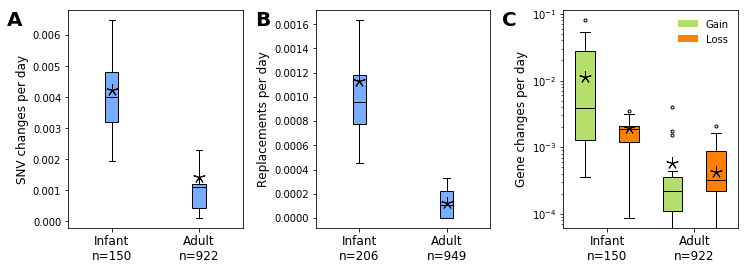

In [159]:
# Combined matched plot
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

tp_types = ['4-8mon duration infant', '4-8mon duration adult']
labels = ['4-8mon\nInfant', '4-8mon\nAdult']

# ====================
# SNP CHANGES
# ====================

boxplots_0 = ax[0].boxplot(snp_change_rates, patch_artist=True, zorder=-1, 
                           medianprops=dict(color='black'), 
                           flierprops=dict(marker='.'))

for i in np.arange(len(snp_change_rates)):
    boxplots_0['boxes'][i].set_facecolor('#77acff')

ax[0].plot(np.arange(1, 1+len(snp_change_rate_annotations)), snp_change_rate_annotations, marker=(5, 2), color='black', linestyle='None', markersize=12)
ax[0].set_xticklabels(['\n'.join(label.split('\n')[1:]) for label in snp_change_rate_tp_type_labels], fontsize=12)
ax[0].set_ylabel("SNV changes per day", fontsize=12)
ax[0].text(-0.35, 0.93, 'A', size=20, transform=ax[0].transAxes, weight='bold')

# ====================
# Replacements
# ====================

boxplots_1 = ax[1].boxplot(replacement_rates, patch_artist=True, zorder=-1, 
                           medianprops=dict(color='black'), 
                           flierprops=dict(marker='.'))

for i in np.arange(len(replacement_rates)):
    boxplots_1['boxes'][i].set_facecolor('#77acff')

ax[1].plot(np.arange(1, 1+len(replacement_rate_annotations)), replacement_rate_annotations, marker=(5, 2), color='black', linestyle='None', markersize=12)
ax[1].set_xticklabels(['\n'.join(label.split('\n')[1:]) for label in replacement_rate_tp_type_labels], fontsize=12)
ax[1].set_ylabel("Replacements per day", fontsize=12)
ax[1].text(-0.35, 0.93, 'B', size=20, transform=ax[1].transAxes, weight='bold')

# ====================
# Gene gain/loss
# ====================
bootstrapped_all_gene_change_rates = []
for gain_rates, loss_rates in zip(bootstrapped_gain_rates, bootstrapped_loss_rates):
    bootstrapped_all_gene_change_rates.append(gain_rates)
    bootstrapped_all_gene_change_rates.append(loss_rates)

all_gene_change_annotations = []
for gain_annotation, loss_annotation in zip(gain_annotations, loss_annotations):
    all_gene_change_annotations.append(gain_annotation)
    all_gene_change_annotations.append(loss_annotation)

boxplots_2 = ax[2].boxplot(bootstrapped_all_gene_change_rates, patch_artist=True, zorder=-1,
                           medianprops=dict(color='black'), 
                           flierprops=dict(marker='.'))

for i in np.arange(len(bootstrapped_all_gene_change_rates), step=2):
    boxplots_2['boxes'][i].set_facecolor('#b3de69') # gain
    boxplots_2['boxes'][i+1].set_facecolor('#ff7f00') # loss

ax[2].plot(np.arange(1, 1+len(all_gene_change_annotations)), all_gene_change_annotations, marker=(5, 2), color='black', linestyle='None', markersize=12)
ax[2].set_xticks(np.arange(2*len(gain_tp_type_labels), step=2) + 1.5)
ax[2].set_xticklabels(['\n'.join(label.split('\n')[1:]) for label in gain_tp_type_labels], fontsize=12)
ax[2].set_ylabel("Gene changes per day", fontsize=12)
ax[2].set_yscale('log')
ax[2].text(-0.35, 0.93, 'C', size=20, transform=ax[2].transAxes, weight='bold')

legend_elements = [Patch(facecolor='#b3de69', label='Gain'), Patch(facecolor='#ff7f00', label='Loss')]

ax[2].legend(handles=legend_elements, loc='upper right', frameon=False)

plt.subplots_adjust(wspace=0.42)
plt.show()

fig.savefig('%s/S8_snv_gene_change_replacement_matched_infant_adult_compare.pdf' % plot_dir, bbox_inches='tight')

In [161]:
# Get t test statistics
t, p = stats.ttest_ind(snp_change_rates[0], snp_change_rates[1])
print("T: %.02f\tp: %.3E" % (t, p))

t, p = stats.ttest_ind(replacement_rates[0], replacement_rates[1])
print("T: %.02f\tp: %.3E" % (t, p))

t, p = stats.ttest_ind(bootstrapped_gain_rates[0], bootstrapped_gain_rates[1])
print("T: %.02f\tp: %.3E" % (t, p))

t, p = stats.ttest_ind(bootstrapped_loss_rates[0], bootstrapped_loss_rates[1])
print("T: %.02f\tp: %.3E" % (t, p))

T: 11.02	p: 2.121E-13
T: 12.32	p: 7.712E-15
T: 2.93	p: 5.636E-03
T: 4.66	p: 3.823E-05


In [63]:
# Get statistics for paper
for tp_type, gain_val, loss_val in zip(tp_types, gain_annotations, loss_annotations):
    print(tp_type)
    print('Avg gain rate: %.3E \t Avg loss rate: %.3E' % (gain_val, loss_val))

Mother-Infant
Avg gain rate: 1.333E-02 	 Avg loss rate: 1.133E-01
Day 0-Week 1
Avg gain rate: 7.798E-02 	 Avg loss rate: 6.881E-02
Week 1-Month 1
Avg gain rate: 1.739E-02 	 Avg loss rate: 3.819E-02
Month 1-Year 1
Avg gain rate: 4.934E-03 	 Avg loss rate: 7.378E-04
Adult-Adult
Avg gain rate: 5.506E-04 	 Avg loss rate: 4.000E-04


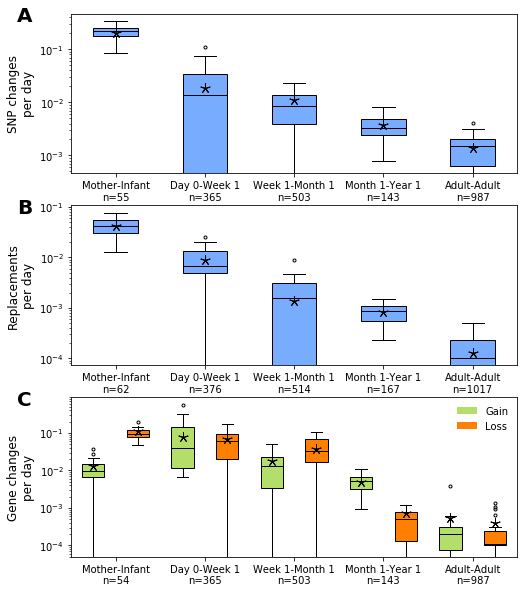

In [116]:
# Combined SNP change, replacement, gene gain and loss rate plot: final version??

fig, ax = plt.subplots(3, 1, figsize=(8, 10))

tp_types = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'Adult-Adult']

boxplots_0 = ax[0].boxplot(snp_change_rates, patch_artist=True, zorder=-1, 
                           medianprops=dict(color='black'), 
                           flierprops=dict(marker='.'))

for i in np.arange(len(snp_change_rates)):
    boxplots_0['boxes'][i].set_facecolor('#77acff')

ax[0].plot(np.arange(1, 1+len(snp_change_rate_annotations)), snp_change_rate_annotations, marker=(5, 2), color='black', linestyle='None', markersize=10)
ax[0].set_xticklabels(snp_change_rate_tp_type_labels)
ax[0].set_ylabel("SNP changes\nper day", fontsize=12)
# ax[0].set_title("SNP changes per non-replacement QP pair per day")
ax[0].set_yscale('log')
ax[0].text(-0.12, 0.95, 'A', size=20, transform=ax[0].transAxes, weight='bold')

boxplots_1 = ax[1].boxplot(replacement_rates, patch_artist=True, zorder=-1, 
                           medianprops=dict(color='black'), 
                           flierprops=dict(marker='.'))

for i in np.arange(len(replacement_rates)):
    boxplots_1['boxes'][i].set_facecolor('#77acff')

ax[1].plot(np.arange(1, 1+len(replacement_rate_annotations)), replacement_rate_annotations, marker=(5, 2), color='black', linestyle='None', markersize=10)
ax[1].set_xticklabels(replacement_rate_tp_type_labels)
ax[1].set_ylabel("Replacements\nper day", fontsize=12)
# ax[1].set_title("Replacements per QP pair per day")
ax[1].set_yscale('log')
ax[1].text(-0.12, 0.95, 'B', size=20, transform=ax[1].transAxes, weight='bold')
    
bootstrapped_all_gene_change_rates = []
for gain_rates, loss_rates in zip(bootstrapped_gain_rates, bootstrapped_loss_rates):
    bootstrapped_all_gene_change_rates.append(gain_rates)
    bootstrapped_all_gene_change_rates.append(loss_rates)

all_gene_change_annotations = []
for gain_annotation, loss_annotation in zip(gain_annotations, loss_annotations):
    all_gene_change_annotations.append(gain_annotation)
    all_gene_change_annotations.append(loss_annotation)

boxplots_2 = ax[2].boxplot(bootstrapped_all_gene_change_rates, patch_artist=True, zorder=-1,
                           medianprops=dict(color='black'), 
                           flierprops=dict(marker='.'))
for i in np.arange(len(bootstrapped_all_gene_change_rates), step=2):
    boxplots_2['boxes'][i].set_facecolor('#b3de69') # gain
    boxplots_2['boxes'][i+1].set_facecolor('#ff7f00') # loss

ax[2].plot(np.arange(1, 1+len(all_gene_change_annotations)), all_gene_change_annotations, marker=(5, 2), color='black', linestyle='None', markersize=10)
ax[2].set_xticks(np.arange(2*len(gain_tp_type_labels), step=2) + 1.5)
ax[2].set_xticklabels(gain_tp_type_labels)
ax[2].set_ylabel("Gene changes\nper day", fontsize=12)
# ax[2].set_title("Gene changes per non-replacement QP pair per day")
ax[2].set_yscale('log')
ax[2].text(-0.12, 0.95, 'C', size=20, transform=ax[2].transAxes, weight='bold')

legend_elements = [Patch(facecolor='#b3de69', label='Gain'), Patch(facecolor='#ff7f00', label='Loss')]

ax[2].legend(handles=legend_elements, loc='upper right', frameon=False)

plt.subplots_adjust(wspace=0, hspace=0.2)
plt.show()

fig.savefig('%s/figure_3_v1.png' % plot_dir, bbox_inches='tight', dpi=600)

In [65]:
# Get statistics for paper
for tp_type, gain_val, loss_val in zip(tp_types, gain_annotations, loss_annotations):
    print(tp_type)
    print('Avg gain rate: %.3E \t Avg loss rate: %.3E' % (gain_val, loss_val))

print('')

t, p = stats.ttest_ind(bootstrapped_gain_rates[0], bootstrapped_loss_rates[0])
print("T: %.02f\tp: %.3E" % (t, p))

t, p = stats.ttest_ind(bootstrapped_gain_rates[3], bootstrapped_loss_rates[3])
print("T: %.02f\tp: %.3E" % (t, p))

Mother-Infant
Avg gain rate: 1.333E-02 	 Avg loss rate: 1.133E-01
Day 0-Week 1
Avg gain rate: 7.798E-02 	 Avg loss rate: 6.881E-02
Week 1-Month 1
Avg gain rate: 1.739E-02 	 Avg loss rate: 3.819E-02
Month 1-Year 1
Avg gain rate: 4.934E-03 	 Avg loss rate: 7.378E-04
Adult-Adult
Avg gain rate: 5.506E-04 	 Avg loss rate: 4.000E-04

T: -10.15	p: 2.284E-12
T: 8.05	p: 9.729E-10


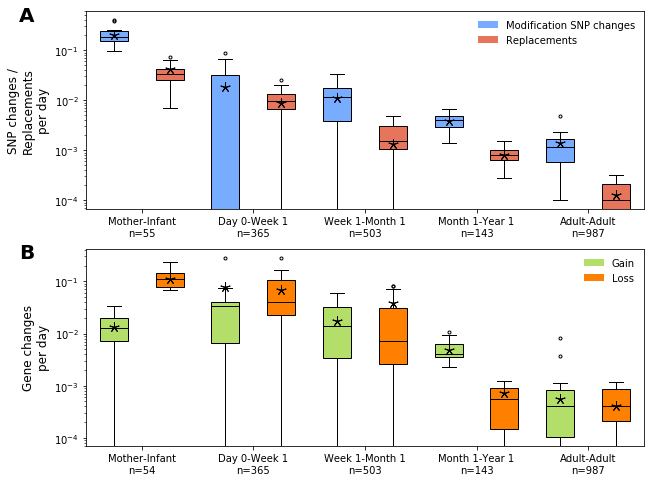

In [66]:
# Combined SNP change, replacement, gene gain and loss rate plot: final version??

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

tp_types = ['MI', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'AA']

bootstrapped_snp_change_and_replacement_rates = []
for sc_rates_cat, r_rates_cat in zip(snp_change_rates, replacement_rates):
    bootstrapped_snp_change_and_replacement_rates.append(sc_rates_cat)
    bootstrapped_snp_change_and_replacement_rates.append(r_rates_cat)

snp_change_and_replacement_annotations = []
for sc_annotation, r_annotation in zip(snp_change_rate_annotations, replacement_rate_annotations):
    snp_change_and_replacement_annotations.append(sc_annotation)
    snp_change_and_replacement_annotations.append(r_annotation)

boxplots_0 = ax[0].boxplot(bootstrapped_snp_change_and_replacement_rates, patch_artist=True, zorder=-1,
                           medianprops=dict(color='black'), 
                           flierprops=dict(marker='.'))
for i in np.arange(len(bootstrapped_snp_change_and_replacement_rates), step=2):
    boxplots_0['boxes'][i].set_facecolor('#77acff') # SNP change
    boxplots_0['boxes'][i+1].set_facecolor('#e7755b') # Replacement

ax[0].plot(np.arange(1, 1+len(snp_change_and_replacement_annotations)), snp_change_and_replacement_annotations, marker=(5, 2), color='black', linestyle='None', markersize=10)
ax[0].set_xticks(np.arange(2*len(snp_change_rate_tp_type_labels), step=2) + 1.5)
ax[0].set_xticklabels(snp_change_rate_tp_type_labels)
ax[0].set_ylabel("SNP changes /\nReplacements\nper day", fontsize=12)
ax[0].set_yscale('log')
ax[0].text(-0.12, 0.95, 'A', size=20, transform=ax[0].transAxes, weight='bold')

legend_elements = [Patch(facecolor='#77acff', label='Modification SNP changes'), Patch(facecolor='#e7755b', label='Replacements')]

ax[0].legend(handles=legend_elements, loc='upper right', frameon=False)

bootstrapped_all_gene_change_rates = []
for gain_rates, loss_rates in zip(bootstrapped_gain_rates, bootstrapped_loss_rates):
    bootstrapped_all_gene_change_rates.append(gain_rates)
    bootstrapped_all_gene_change_rates.append(loss_rates)

all_gene_change_annotations = []
for gain_annotation, loss_annotation in zip(gain_annotations, loss_annotations):
    all_gene_change_annotations.append(gain_annotation)
    all_gene_change_annotations.append(loss_annotation)

boxplots_1 = ax[1].boxplot(bootstrapped_all_gene_change_rates, patch_artist=True, zorder=-1,
                           medianprops=dict(color='black'), 
                           flierprops=dict(marker='.'))
for i in np.arange(len(bootstrapped_all_gene_change_rates), step=2):
    boxplots_1['boxes'][i].set_facecolor('#b3de69') # gain
    boxplots_1['boxes'][i+1].set_facecolor('#ff7f00') # loss

ax[1].plot(np.arange(1, 1+len(all_gene_change_annotations)), all_gene_change_annotations, marker=(5, 2), color='black', linestyle='None', markersize=10)
ax[1].set_xticks(np.arange(2*len(gain_tp_type_labels), step=2) + 1.5)
ax[1].set_xticklabels(gain_tp_type_labels)
ax[1].set_ylabel("Gene changes\nper day", fontsize=12)
ax[1].set_yscale('log')
ax[1].text(-0.12, 0.95, 'B', size=20, transform=ax[1].transAxes, weight='bold')

legend_elements = [Patch(facecolor='#b3de69', label='Gain'), Patch(facecolor='#ff7f00', label='Loss')]

ax[1].legend(handles=legend_elements, loc='upper right', frameon=False)

plt.subplots_adjust(wspace=0, hspace=0.2)
plt.show()

fig.savefig('%s/figure_3_v2.png' % plot_dir, bbox_inches='tight', dpi=600)

In [67]:
# Plot SNP change distribution with all infant-infant QP pairs combined

def custom_cohort_of_sample_pair(custom_cohort_tests, sample_i, sample_j):
    for cohort in custom_cohort_tests:
        if custom_cohort_tests[cohort](sample_i, sample_j):
            return cohort

custom_cohort_tests = {}
# custom_cohort_tests['MI'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in infant_samples)
custom_cohort_tests['MI'] = lambda sample_i, sample_j: ((sample_i in mother_samples and sample_j in infant_samples) and mi_sample_day_dict[sample_i] >= 0 and mi_sample_day_dict[sample_j] <= 7)
custom_cohort_tests['II-1mon'] = lambda sample_i, sample_j: ((sample_i in infant_samples and sample_j in infant_samples) and (sample_pair_to_days(sample_i, sample_j) <= 32))
custom_cohort_tests['II-1yr'] = lambda sample_i, sample_j: ((sample_i in infant_samples and sample_j in infant_samples) and (sample_pair_to_days(sample_i, sample_j) > 90))
custom_cohort_tests['MM'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in mother_samples)
custom_cohort_tests['AA'] = lambda sample_i, sample_j: (sample_i in hmp_samples and sample_j in hmp_samples)

pooled_snp_change_distribution = defaultdict(list)
pooled_between_snp_change_distribution = defaultdict(list)

time_length_dist = []

for species in snp_changes:
    for sample_i, sample_j in snp_changes[species]:        
        val = snp_changes[species][(sample_i, sample_j)]
        num_snp_changes = val if (type(val) == type(1)) else len(val)
        custom_cohort = custom_cohort_of_sample_pair(custom_cohort_tests, sample_i, sample_j)
        if custom_cohort == 'II-1yr':
            time_length_dist.append(sample_pair_to_days(sample_i, sample_j))
        pooled_snp_change_distribution[custom_cohort].append(num_snp_changes)
        
        num_snp_changes_between = between_snp_change_counts[species][(sample_i, sample_j)]
        if sample_i in hmp_samples and sample_j in hmp_samples:
            pooled_between_snp_change_distribution['AA'].append(num_snp_changes_between)
        else:
            pooled_between_snp_change_distribution['MI'].append(num_snp_changes_between)

In [68]:
pooled_snp_change_distribution.keys()

['AA', 'II-1mon', 'MI', None, 'II-1yr']

In [ ]:
# Old and scrapped custom cohort code
custom_cohort_tests = {}
custom_cohort_tests['MI'] = lambda sample_i, sample_j: ((sample_i in mother_samples and sample_j in infant_samples) and mi_sample_day_dict[sample_i] >= 0 and mi_sample_day_dict[sample_j] <= 7)
custom_cohort_tests['MI-other'] = lambda sample_i, sample_j: ((sample_i in mother_samples and sample_j in infant_samples))
custom_cohort_tests['II'] = lambda sample_i, sample_j: (sample_i in infant_samples and sample_j in infant_samples)
custom_cohort_tests['MM'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in mother_samples)
custom_cohort_tests['AA'] = lambda sample_i, sample_j: (sample_i in hmp_samples and sample_j in hmp_samples)

In [75]:
# Get statistics for paper

pooled_snp_change_distribution = defaultdict(list)
pooled_between_snp_change_distribution = defaultdict(list)

time_length_dist = []

for species in snp_changes:
    for sample_i, sample_j in snp_changes[species]:
        
        val = snp_changes[species][(sample_i, sample_j)]
        num_snp_changes = val if (type(val) == type(1)) else len(val)
        num_snp_changes_between = between_snp_change_counts[species][(sample_i, sample_j)]
        custom_cohorts = custom_cohorts_of_sample_pair(custom_cohort_tests, sample_i, sample_j, species)
        '''
        if custom_cohort == None:
            print(sample_order_map[sample_i])
            print(sample_order_map[sample_j])
        '''
        time_length_dist.append(sample_pair_to_days(sample_i, sample_j))
        
        for custom_cohort in custom_cohorts:
            pooled_snp_change_distribution[custom_cohort].append(num_snp_changes)
            pooled_between_snp_change_distribution[custom_cohort].append(num_snp_changes_between)

'''
Most QP sample pairs experience zero SNV changes over timescales of less than a week, 
but a small percentage undergo a small number of SNV changes (< 20). 
An even smaller percentage of hosts harbor ~104 SNV differences, 
which is on the same order of magnitude of the number of SNV differences between unrelated hosts
'''

print("\nWITHIN\n")
for tp_type in pooled_snp_change_distribution:
    print(tp_type)
    num_total = len(pooled_snp_change_distribution[tp_type])
    num_zero = sum(np.array(pooled_snp_change_distribution[tp_type]) == 0)
    num_small = sum(np.array(pooled_snp_change_distribution[tp_type]) < 20)
    num_mod = num_small - num_zero
    num_large = sum(np.array(pooled_snp_change_distribution[tp_type]) > 500)
    print("%i out of %i (%.03f) QP pairs have 0 SNP diffs" % (num_zero, num_total, float(num_zero)/num_total))
    print("%i out of %i (%.03f) QP pairs have less than 20 SNP diffs" % (num_small, num_total, float(num_small)/num_total))
    print("%i out of %i (%.03f) QP pairs have 1-20 SNP diffs" % (num_mod, num_total, float(num_mod)/num_total))
    print("%i out of %i (%.03f) QP pairs have greater than 500 SNP diffs" % (num_large, num_total, float(num_large)/num_total))
    print('')

print("\nBETWEEN\n")
for tp_type in pooled_between_snp_change_distribution:
    print(tp_type)
    num_total = len(pooled_between_snp_change_distribution[tp_type])
    num_zero = sum(np.array(pooled_between_snp_change_distribution[tp_type]) == 0)
    num_small = sum(np.array(pooled_between_snp_change_distribution[tp_type]) < 20)
    num_mod = num_small - num_zero
    num_large = sum(np.array(pooled_between_snp_change_distribution[tp_type]) > 500)
    print("%i out of %i (%.03f) QP pairs have 0 SNP diffs" % (num_zero, num_total, float(num_zero)/num_total))
    print("%i out of %i (%.03f) QP pairs have less than 20 SNP diffs" % (num_small, num_total, float(num_small)/num_total))
    print("%i out of %i (%.03f) QP pairs have 1-20 SNP diffs" % (num_mod, num_total, float(num_mod)/num_total))
    print("%i out of %i (%.03f) QP pairs have greater than 500 SNP diffs" % (num_large, num_total, float(num_large)/num_total))
    print('')


WITHIN

4-8mon duration infant
103 out of 206 (0.500) QP pairs have 0 SNP diffs
150 out of 206 (0.728) QP pairs have less than 20 SNP diffs
47 out of 206 (0.228) QP pairs have 1-20 SNP diffs
52 out of 206 (0.252) QP pairs have greater than 500 SNP diffs

Mother-Infant(all)
105 out of 218 (0.482) QP pairs have 0 SNP diffs
179 out of 218 (0.821) QP pairs have less than 20 SNP diffs
74 out of 218 (0.339) QP pairs have 1-20 SNP diffs
38 out of 218 (0.174) QP pairs have greater than 500 SNP diffs

6mon duration infant
11 out of 25 (0.440) QP pairs have 0 SNP diffs
16 out of 25 (0.640) QP pairs have less than 20 SNP diffs
5 out of 25 (0.200) QP pairs have 1-20 SNP diffs
9 out of 25 (0.360) QP pairs have greater than 500 SNP diffs

4-8mon duration adult
850 out of 949 (0.896) QP pairs have 0 SNP diffs
921 out of 949 (0.970) QP pairs have less than 20 SNP diffs
71 out of 949 (0.075) QP pairs have 1-20 SNP diffs
22 out of 949 (0.023) QP pairs have greater than 500 SNP diffs

Day 0-Week 1
359 o

In [78]:
# Understand durations and initial timpeoints of II-1mon and II-1yr categories

custom_cohort_durations = defaultdict(list)
custom_cohort_day1s = defaultdict(list)

for species in snp_changes:
    for sample_i, sample_j in snp_changes[species]:
        
        custom_cohorts = custom_cohorts_of_sample_pair(custom_cohort_tests, sample_i, sample_j, species)
        days = sample_pair_to_days(sample_i, sample_j)
        day1 = mi_sample_day_dict[sample_i] if sample_i in mi_sample_day_dict else -1
        
        for custom_cohort in custom_cohorts:
            custom_cohort_durations[custom_cohort].append(days)
            custom_cohort_day1s[custom_cohort].append(day1)

II-1mon category
Day 1	Count
0	4
1	11
3	16
4	410
6	2
7	415
8	4
9	5
10	13
11	9
12	13
13	2
14	52
18	1
30	57
61	64



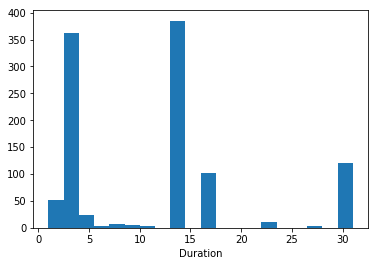

In [92]:
# Print histogram for list of integers
def print_histogram(vals):
    for val in sorted(list(set(vals))):
        print("%i\t%i" % (val, vals.count(val)))
    print('')

print("=============================================")
print("II-1mon category")
print("=============================================")
print("Day 1\tCount")
print_histogram(custom_cohort_day1s['II-1mon'])

plt.hist(custom_cohort_durations['II-1mon'], bins=20)
plt.xlabel("Duration")
plt.show()

II-1yr category
Day 1	Count
0	1
1	1
3	117
4	12
7	93
21	92
30	10
122	103



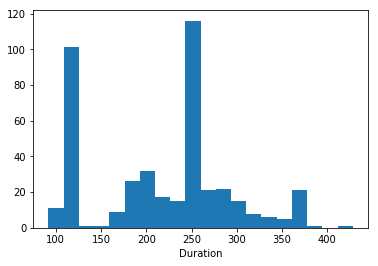

In [93]:
print("=============================================")
print("II-1yr category")
print("=============================================")

print("Day 1\tCount")
print_histogram(custom_cohort_day1s['II-1yr'])

plt.hist(custom_cohort_durations['II-1yr'], bins=20)
plt.xlabel("Duration")
plt.show()

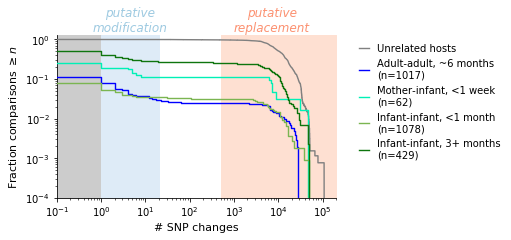

In [95]:
# Plut SNP change distribution survival curve plot

fig_snp, ax_snp = plt.subplots(figsize=(5,3))

colormap = cmx.get_cmap('viridis', 8)
colors = [colormap(x) for x in np.array([x for x in range(0,8)])/8.0]
colors = ['gray', 'blue', '#00f0b6', '#7bb551', '#0e750e']

modification_difference_threshold = config.modification_difference_threshold
replacement_difference_threshold = config.replacement_difference_threshold

ax_snp.set_xscale('log')
ax_snp.set_yscale('log')
ax_snp.set_ylabel('Fraction comparisons $\geq n$', fontsize=11)
ax_snp.set_xlabel('# SNP changes', fontsize=11)

ax_snp.spines['top'].set_visible(False)
ax_snp.spines['right'].set_visible(False)
ax_snp.get_xaxis().tick_bottom()
ax_snp.get_yaxis().tick_left()

color_i = 0

ymin, ymax = 0.0001, 1.3
ax_snp.set_ylim([ymin,ymax])
xmin, xmax = 1e-01, 2e05
ax_snp.set_xlim([xmin, xmax])

# Now fill in the graphics

ax_snp.fill_between([xmin,1], [ymin,ymin],[ymax,ymax],color='0.8',zorder=1)
ax_snp.fill_between([1,modification_difference_threshold],[ymin,ymin],[ymax,ymax],color='#deebf7',zorder=1)
ax_snp.fill_between([replacement_difference_threshold,xmax],[ymin,ymin],[ymax,ymax],color='#fee0d2',zorder=1)

ax_snp.text( exp((log(1e05)+log(replacement_difference_threshold))/2), ymax*1.2, 'putative\nreplacement',fontsize=12,fontstyle='italic',ha='center',color='#fc9272',zorder=1)
ax_snp.text( exp((log(1)+log(modification_difference_threshold))/2), ymax*1.2, 'putative\nmodification',fontsize=12,fontstyle='italic',ha='center',color='#9ecae1',zorder=1)

# Unrelated hosts (adults OR mother/infant)
counts = []
for cat in ['Adult-Adult', 'Mother-Infant', 'II-1mon', 'II-1yr']:
    counts += pooled_between_snp_change_distribution[cat]
# counts = pooled_between_snp_change_distribution['Adult-Adult'] + pooled_between_snp_change_distribution['Mother-Infant'] + pooled_between_snp_change_distribution['Infant-Infant']
xs, ns = calculate_unnormalized_survival_from_vector(counts)
ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label="Unrelated hosts", where='pre',zorder=4)
color_i += 1

# Within-host, adult
counts = pooled_snp_change_distribution['Adult-Adult']
xs, ns = calculate_unnormalized_survival_from_vector(counts)
mlabel = 'Adult-adult, ~6 months' + ('\n(n=%d)' % ns[0])
ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=mlabel, where='pre',zorder=4)
color_i += 1

# Within-host, mother-infant
counts = pooled_snp_change_distribution['Mother-Infant']
xs, ns = calculate_unnormalized_survival_from_vector(counts)
mlabel = "Mother-infant, <1 week" + ('\n(n=%d)' % ns[0])
ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=mlabel, where='pre',zorder=4)
color_i += 1

# Within-host, infant-infant
for infant_custom_cohort, infant_custom_label in zip(['II-1mon', 'II-1yr'], ['Infant-infant, <1 month', 'Infant-infant, 3+ months']):
    counts = pooled_snp_change_distribution[infant_custom_cohort]
    xs, ns = calculate_unnormalized_survival_from_vector(counts)
    mlabel = ('%s\n(n=%d)' % (infant_custom_label, ns[0]))
    ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=mlabel, where='pre',zorder=4)
    color_i += 1

# Save
ax_snp.legend(loc='best', bbox_to_anchor=(1.05, 1), fontsize=10, numpoints=1, ncol=1, handlelength=1, frameon=False)
fig_snp.savefig('%s/temporal_snp_changes_%s_pooled_infant_combined_v2.pdf' % (config.analysis_directory, sweep_type),bbox_inches='tight',dpi=600)
plt.show()

In [131]:
# Compare between with within, combined across Adult-Adult, Mother-Infant, II-1mon and II-1yr
# cats = ['Adult-Adult', 'Mother-Infant', 'II-1mon', 'II-1yr']
cats = ['Mother-Infant']
between_counts = []
within_counts = []
for cat in cats:
    between_counts += pooled_between_snp_change_distribution[cat]
    within_counts += pooled_snp_change_distribution[cat]

for counts in [between_counts, within_counts]:
    num_zero = 0
    num_mod = 0
    num_replace = 0
    for count in counts:
        if count == 0:
            num_zero += 1
        elif count <= 20:
            num_mod += 1
        elif count > 500:
            num_replace += 1

    print("Proportion no change: %.04f" % (float(num_zero)/len(counts)))
    print("Proportion <= 20: %.04f" % (float(num_mod)/len(counts)))
    print("Proportion > 500: %.04f" % (float(num_replace)/len(counts)))
    print('')

Proportion no change: 0.0000
Proportion <= 20: 0.0000
Proportion > 500: 1.0000

Proportion no change: 0.7419
Proportion <= 20: 0.1452
Proportion > 500: 0.1129



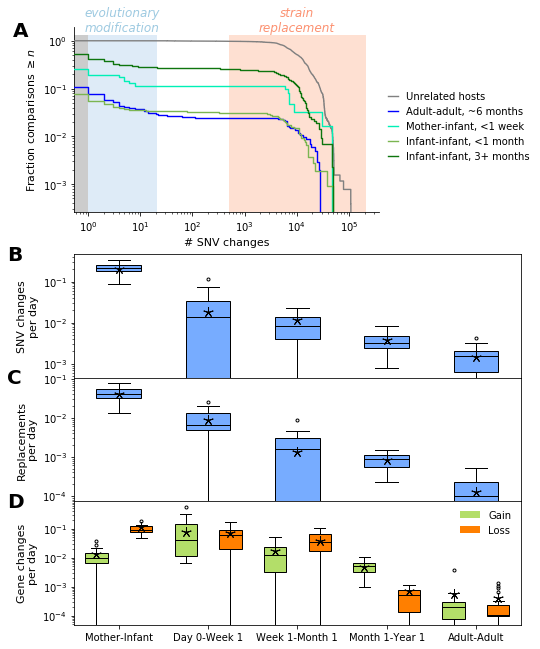

In [125]:
# Combined SNP change, replacement, gene gain and loss rate plot, AND SNP changes plot

# fig, ax = plt.subplots(4, 1, figsize=(8, 16), gridspec_kw={'height_ratios': [1, 1, 1, 1]})
fig = plt.figure(figsize=(8, 11))
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[3, 6], hspace=0.15)

ax = []
# =============================================================================================
# First SNP diff survival curve plot
# =============================================================================================

ax.append(fig.add_subplot(gs[0, 0]))

colormap = cmx.get_cmap('viridis', 8)
colors = [colormap(x) for x in np.array([x for x in range(0,8)])/8.0]
colors = ['gray', 'blue', '#00f0b6', '#7bb551', '#0e750e']

modification_difference_threshold = config.modification_difference_threshold
replacement_difference_threshold = config.replacement_difference_threshold

ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].set_ylabel('Fraction comparisons $\geq n$', fontsize=11)
ax[0].set_xlabel('# SNV changes', fontsize=11)

ax[0].spines['top'].set_visible(False); ax[0].spines['right'].set_visible(False)
ax[0].get_xaxis().tick_bottom(); ax[0].get_yaxis().tick_left()

color_i = 0

ymin, ymax = 0, 1.3
ax_snp.set_ylim([ymin,ymax])
xmin, xmax = 0, 2e05
ax_snp.set_xlim([xmin, xmax])

# Now fill in the graphics

ax[0].fill_between([xmin,1], [ymin,ymin],[ymax,ymax],color='0.8',zorder=1)
ax[0].fill_between([1,modification_difference_threshold],[ymin,ymin],[ymax,ymax],color='#deebf7',zorder=1)
ax[0].fill_between([replacement_difference_threshold,xmax],[ymin,ymin],[ymax,ymax],color='#fee0d2',zorder=1)

ax[0].text( exp((log(xmax)+log(replacement_difference_threshold))/2), ymax*1.2, 'strain\nreplacement',fontsize=12,fontstyle='italic',ha='center',color='#fc9272',zorder=1)
ax[0].text( exp((log(1)+log(modification_difference_threshold))/2), ymax*1.2, 'evolutionary\nmodification',fontsize=12,fontstyle='italic',ha='center',color='#9ecae1',zorder=1)

# Unrelated hosts (adults OR mother/infant)
counts = []
for cat in ['Adult-Adult', 'Mother-Infant', 'II-1mon', 'II-1yr']:
    counts += pooled_between_snp_change_distribution[cat]
xs, ns = calculate_unnormalized_survival_from_vector(counts)
ax[0].step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label="Unrelated hosts", where='pre',zorder=4)
color_i += 1

# Within-host, adult
counts = pooled_snp_change_distribution['Adult-Adult']
xs, ns = calculate_unnormalized_survival_from_vector(counts)
mlabel = 'Adult-adult, ~6 months' # + ('\n(n=%d)' % ns[0])
ax[0].step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=mlabel, where='pre',zorder=4)
color_i += 1

# Within-host, mother-infant
counts = pooled_snp_change_distribution['Mother-Infant']
xs, ns = calculate_unnormalized_survival_from_vector(counts)
mlabel = "Mother-infant, <1 week" # + ('\n(n=%d)' % ns[0])
ax[0].step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=mlabel, where='pre',zorder=4)
color_i += 1

# Within-host, infant-infant
for infant_custom_cohort, infant_custom_label in zip(['II-1mon', 'II-1yr'], ['Infant-infant, <1 month', 'Infant-infant, 3+ months']):
    counts = pooled_snp_change_distribution[infant_custom_cohort]
    xs, ns = calculate_unnormalized_survival_from_vector(counts)
    mlabel = ('%s' % (infant_custom_label)) # mlabel = ('%s\n(n=%d)' % (infant_custom_label, ns[0]))
    ax[0].step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=mlabel, where='pre',zorder=4)
    color_i += 1

ax[0].legend(loc='best', bbox_to_anchor=(1.002, 0.7), fontsize=10, numpoints=1, ncol=1, handlelength=1, frameon=False)
ax[0].text(-0.2, 0.95, 'A', size=20, transform=ax[0].transAxes, weight='bold')
# =============================================================================================

ylabel_size=11
tp_types = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'Adult-Adult']

gs1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[1, :], hspace=0)
ax_snps = fig.add_subplot(gs1[0])
ax.append(ax_snps)
boxplots_0 = ax[1].boxplot(snp_change_rates, patch_artist=True, zorder=-1, 
                           medianprops=dict(color='black'), 
                           flierprops=dict(marker='.'))

for i in np.arange(len(snp_change_rates)):
    boxplots_0['boxes'][i].set_facecolor('#77acff')

ax[1].plot(np.arange(1, 1+len(snp_change_rate_annotations)), snp_change_rate_annotations, marker=(5, 2), color='black', linestyle='None', markersize=10)
# ax[1].set_xticklabels(snp_change_rate_tp_type_labels)
ax[1].get_xaxis().set_visible(False)
ax[1].set_ylabel("SNV changes\nper day", fontsize=ylabel_size)
# ax[0].set_title("SNP changes per non-replacement QP pair per day")
ax[1].set_yscale('log')
ax[1].text(-0.15, 0.95, 'B', size=20, transform=ax[1].transAxes, weight='bold')

ax.append(fig.add_subplot(gs1[1]))
boxplots_1 = ax[2].boxplot(replacement_rates, patch_artist=True, zorder=-1, 
                           medianprops=dict(color='black'), 
                           flierprops=dict(marker='.'))

for i in np.arange(len(replacement_rates)):
    boxplots_1['boxes'][i].set_facecolor('#77acff')

ax[2].plot(np.arange(1, 1+len(replacement_rate_annotations)), replacement_rate_annotations, marker=(5, 2), color='black', linestyle='None', markersize=10)
# ax[2].set_xticklabels(replacement_rate_tp_type_labels)
ax[2].get_xaxis().set_visible(False)
ax[2].set_ylabel("Replacements\nper day", fontsize=ylabel_size)
# ax[1].set_title("Replacements per QP pair per day")
ax[2].set_yscale('log')
ax[2].text(-0.15, 0.95, 'C', size=20, transform=ax[2].transAxes, weight='bold')
    
bootstrapped_all_gene_change_rates = []
for gain_rates, loss_rates in zip(bootstrapped_gain_rates, bootstrapped_loss_rates):
    bootstrapped_all_gene_change_rates.append(gain_rates)
    bootstrapped_all_gene_change_rates.append(loss_rates)

all_gene_change_annotations = []
for gain_annotation, loss_annotation in zip(gain_annotations, loss_annotations):
    all_gene_change_annotations.append(gain_annotation)
    all_gene_change_annotations.append(loss_annotation)

ax.append(fig.add_subplot(gs1[2]))
boxplots_2 = ax[3].boxplot(bootstrapped_all_gene_change_rates, patch_artist=True, zorder=-1,
                           medianprops=dict(color='black'), 
                           flierprops=dict(marker='.'))
for i in np.arange(len(bootstrapped_all_gene_change_rates), step=2):
    boxplots_2['boxes'][i].set_facecolor('#b3de69') # gain
    boxplots_2['boxes'][i+1].set_facecolor('#ff7f00') # loss

ax[3].plot(np.arange(1, 1+len(all_gene_change_annotations)), all_gene_change_annotations, marker=(5, 2), color='black', linestyle='None', markersize=10)
ax[3].set_xticks(np.arange(2*len(gain_tp_type_labels), step=2) + 1.5)
ax[3].set_xticklabels(tp_types) # ax[3].set_xticklabels(gain_tp_type_labels)
ax[3].set_ylabel("Gene changes\nper day", fontsize=ylabel_size)
# ax[2].set_title("Gene changes per non-replacement QP pair per day")
ax[3].set_yscale('log')
ax[3].text(-0.15, 0.95, 'D', size=20, transform=ax[3].transAxes, weight='bold')

legend_elements = [Patch(facecolor='#b3de69', label='Gain'), Patch(facecolor='#ff7f00', label='Loss')]

ax[3].legend(handles=legend_elements, loc='upper right', frameon=False)

# plt.subplots_adjust(wspace=0, hspace=0.3)
plt.show()

fig.savefig('%s/figure_3_v5.png' % plot_dir, bbox_inches='tight', dpi=600)
fig.savefig('%s/figure_3_v5.pdf' % plot_dir, bbox_inches='tight')

In [180]:
# Linear regression
# log(SNV rates) vs. log(infant timepoint)

adult_interval_days = 183
adult_initial_days = 40*365

# Store SNP change information: including starting day

replacement_time_tups_by_tp_type = defaultdict(list)
all_time_tups_by_tp_type = defaultdict(list)

for species in snp_changes:
    for s1, s2 in snp_changes[species]:
        
        val = snp_changes[species][(s1, s2)]        
        custom_cohorts = custom_cohorts_of_sample_pair(custom_cohort_tests, s1, s2, species)
        days = sample_pair_to_days(s1, s2)
        
        # Skip negative days for now (seems to be either Yassour 3rd mom tp, Ferretti reverse IM)
        if days < 0:
            continue
        
        # Arbitrarily set mother 0 - infant 0 as 1 day
        if is_mother(s1) and mi_sample_day_dict[s1] == 0 and is_infant(s2) and mi_sample_day_dict[s2] == 0:
            days = 1
        
        if 'Adult-Adult' in custom_cohorts:
            day1 = adult_initial_days + ((sample_order_map[s1][1]-1)*adult_interval_days)
        else:
            day1 = mi_sample_day_dict[s1]
        
        if isinstance(val, int): # Replacement
            for custom_cohort in custom_cohorts:
                replacement_time_tups_by_tp_type[custom_cohort].append((1, days, day1))
                all_time_tups_by_tp_type[custom_cohort].append((val, days, day1))
        else: # Not replacement (modifications/no change)
            for custom_cohort in custom_cohorts:
                count_time_tups_by_tp_type[custom_cohort].append((len(val), days, day1))
                all_time_tups_by_tp_type[custom_cohort].append((len(val), days, day1))

# Store gene change information: include starting day

gain_tups_by_tp_type = defaultdict(list)
loss_tups_by_tp_type = defaultdict(list)

for species in gene_changes:
    for s1, s2 in gene_changes[species]:
        
        gains, losses = gene_changes[species][(s1, s2)]
        custom_cohorts = custom_cohorts_of_sample_pair(custom_cohort_tests, s1, s2, species)
        days = sample_pair_to_days(s1, s2)
        
        # Skip negative days for now (seems to be either Yassour 3rd mom tp, Ferretti reverse IM)
        if days < 0:
            continue
        
        # Arbitrarily set mother 0 - infant 0 as 1 day
        if is_mother(s1) and mi_sample_day_dict[s1] == 0 and is_infant(s2) and mi_sample_day_dict[s2] == 0:
            days = 1
        
        if 'Adult-Adult' in custom_cohorts:
            day1 = adult_initial_days + ((sample_order_map[s1][1]-1)*adult_interval_days)
        else:
            day1 = mi_sample_day_dict[s1]
        
        if isinstance(snp_changes[species][(s1, s2)], int): # Replacement (in terms of SNP changes)
            continue# num_gains, num_losses = gene_changes[species][(s1, s2)]
        else:
            num_gains = len(gene_changes[species][(s1, s2)][0])
            num_losses = len(gene_changes[species][(s1, s2)][1])
        
        for custom_cohort in custom_cohorts:
            gain_tups_by_tp_type[custom_cohort].append((num_gains, days, day1))
            loss_tups_by_tp_type[custom_cohort].append((num_losses, days, day1))

In [181]:
tp_types = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'Adult-Adult']

gain_rates = []
gain_day1s = []
gain_means = []

loss_rates = []
loss_day1s = []
loss_means = []

rates = [] # Modification SNP change rate
day1s = []
means = []

gain_middle_days_lists = []
loss_middle_days_lists = []
middle_days_lists = []

for tp_type in tp_types:
    
    # SNP change rates ========================================================
    total_count = 0; total_days = 0
    middle_days = []
    
    for count, days, day1 in all_time_tups_by_tp_type[tp_type]:
        if count <= 20: # Restrict to modification/no change
            rate = count/float(days)

            if day1 == 0:
                day1 = 0.1 # Arbitrary number << 1 for visualization purposes
            if count == 0:
                rate = 0 # Arbitrary number << 0.002 for visualization purposes

            rates.append(rate)
            day1s.append(day1)

            total_count += count
            total_days += days
            middle_days.append((day1) + (days/2.0))
    
    middle_days_lists.append(middle_days)
    means.append(total_count/float(total_days))
    # ==========================================================================
    
    # Gene gain rates ==========================================================
    total_count = 0; total_days = 0
    middle_days = []
    
    for count, days, day1 in gain_tups_by_tp_type[tp_type]:
        # Already excludes replacements
        rate = count/float(days)
        
        if day1 == 0:
            day1 = 0.1 # Arbitrary number << 1 for visualization purposes
        
        gain_rates.append(rate)
        gain_day1s.append(day1)
        
        total_count += count
        total_days += days
        middle_days.append((day1) + (days/2.0))
    
    gain_middle_days_lists.append(middle_days)
    gain_means.append(total_count/float(total_days))
    # ==========================================================================
    
    # Gene loss rates ==========================================================
    total_count = 0; total_days = 0
    middle_days = []
    
    for count, days, day1 in loss_tups_by_tp_type[tp_type]:
        # Already excludes replacements
        rate = count/float(days)
        
        if day1 == 0:
            day1 = 0.1 # Arbitrary number << 1 for visualization purposes
        
        loss_rates.append(rate)
        loss_day1s.append(day1)
        
        total_count += count
        total_days += days
        middle_days.append((day1) + (days/2.0))
    
    loss_middle_days_lists.append(middle_days)
    loss_means.append(total_count/float(total_days))
    # ==========================================================================

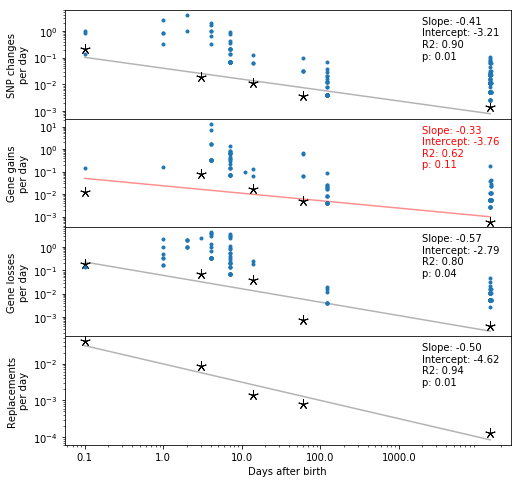

In [183]:
fig, ax = plt.subplots(4, 1, figsize=(8, 8), sharex=True) # , sharey=True)

xs = np.array([0.1, 3, 14, 60, 14600])
ax[0].plot([0.1, 3, 14, 60, 14600], means, marker=(5, 2), color='black', linestyle='None', markersize=10)
ax[0].plot(day1s, rates, '.')

m, b = np.polyfit(np.log(xs), np.log(means), deg=1)
r2 = np.corrcoef(np.log(xs), np.log(means))[0, 1]**2
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(xs),np.log(means))
ax[0].plot(xs, np.exp(m*np.log(xs) + b), color='0.7', zorder=-1)
ax[0].text(0.8, 0.55, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f\np: %.02f" % (m, b, r2, p_value), transform=ax[0].transAxes)

ax[0].set_yscale('log')
ax[0].set_xscale('log')

ax[0].set_ylabel("SNP changes\nper day")

# ================================================================================

ax[1].plot([0.1, 3, 14, 60, 14600], gain_means, marker=(5, 2), color='black', linestyle='None', markersize=10)
ax[1].plot(gain_day1s, gain_rates, '.')

m, b = np.polyfit(np.log(xs), np.log(gain_means), deg=1)
r2 = np.corrcoef(np.log(xs), np.log(gain_means))[0, 1]**2
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(xs),np.log(gain_means))
ax[1].plot(xs, np.exp(m*np.log(xs) + b), color='red', alpha=0.44, zorder=-1)
ax[1].text(0.8, 0.55, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f\np: %.02f" % (m, b, r2, p_value), transform=ax[1].transAxes,
          color='red')

ax[1].set_yscale('log')
ax[1].set_xscale('log')

ax[1].set_ylabel("Gene gains\nper day")

# ================================================================================

ax[2].plot([0.1, 3, 14, 60, 14600], loss_means, marker=(5, 2), color='black', linestyle='None', markersize=10)
ax[2].plot(loss_day1s, loss_rates, '.')

m, b = np.polyfit(np.log(xs), np.log(loss_means), deg=1)
r2 = np.corrcoef(np.log(xs), np.log(loss_means))[0, 1]**2
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(xs),np.log(loss_means))
ax[2].plot(xs, np.exp(m*np.log(xs) + b), color='0.7', zorder=-1)
ax[2].text(0.8, 0.55, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f\np: %.02f" % (m, b, r2, p_value), transform=ax[2].transAxes)

ax[2].set_yscale('log')
ax[2].set_xscale('log')

ax[2].set_ylabel("Gene losses\nper day")

# ================================================================================
replace_means = replacement_rate_annotations

ax[3].plot([0.1, 3, 14, 60, 14600], replace_means, marker=(5, 2), color='black', linestyle='None', markersize=10)

m, b = np.polyfit(np.log(xs), np.log(replace_means), deg=1)
r2 = np.corrcoef(np.log(xs), np.log(replace_means))[0, 1]**2
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(xs),np.log(replace_means))
ax[3].plot(xs, np.exp(m*np.log(xs) + b), color='0.7', zorder=-1)
ax[3].text(0.8, 0.55, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f\np: %.02f" % (m, b, r2, p_value), transform=ax[3].transAxes)

ax[3].set_yscale('log')

ax[3].set_xlabel("Days after birth")
ax[3].set_ylabel("Replacements\nper day")

ax[3].set_xticks([1e-1, 1, 10, 100, 1000])
ax[3].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.subplots_adjust(hspace=0)
plt.show()

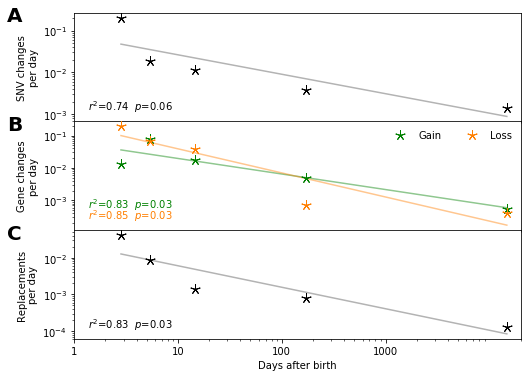

In [184]:
# Second version: put gains and losses on same subplot

gain_color = 'green'
loss_color = '#ff7f00'

fig, ax = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

xs = np.array([0.1, 3, 14, 60, 14600])
xs = [np.mean(days) for days in middle_days_lists]
ax[0].plot(xs, means, marker=(5, 2), color='black', linestyle='None', markersize=10)
# ax[0].scatter(xs, means, marker='D', color='black', linestyle='None', s=16)
# ax[0].scatter(day1s, rates, alpha=0.6)

m, b = np.polyfit(np.log(xs), np.log(means), deg=1)
r2 = np.corrcoef(np.log(xs), np.log(means))[0, 1]**2
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(xs),np.log(means))
ax[0].plot(xs, np.exp(m*np.log(xs) + b), color='0.7', zorder=-1)
ax[0].text(0.03, 0.1, r'$r^2$=%.02f  $\it{p}$=%.02f' % (r2, p_value), transform=ax[0].transAxes)
# ax[0].text(0.8, 0.55, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f\np: %.02f" % (m, b, r2, p_value), transform=ax[0].transAxes)
ax[0].text(-0.15, 0.92, 'A', size=20, transform=ax[0].transAxes, weight='bold')

ax[0].set_yscale('log')
ax[0].set_xscale('log')

ax[0].set_ylabel("SNV changes\nper day")

# ================================================================================

xs = [np.mean(days) for days in gain_middle_days_lists]

legend_elements = [Patch(facecolor='#b3de69', label='Gain'), Patch(facecolor='#ff7f00', label='Loss')]

ax[1].plot(xs, gain_means, marker=(5, 2), color=gain_color, linestyle='None', markersize=10, zorder=5, label='Gain')
# gainr_all = ax[1].scatter(xs, gain_means, marker='^', color='green', linestyle='None', s=16, zorder=5, label='Gain')
# gainr_means = ax[1].scatter(gain_day1s, gain_rates, color='#b3de69', alpha=0.6, label='Gain')

m, b = np.polyfit(np.log(xs), np.log(gain_means), deg=1)
r2 = np.corrcoef(np.log(xs), np.log(gain_means))[0, 1]**2
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(xs),np.log(gain_means))
ax[1].plot(xs, np.exp(m*np.log(xs) + b), color=gain_color, alpha=0.44, zorder=-2)
ax[1].text(0.03, 0.2, r'$r^2$=%.02f  $\it{p}$=%.02f' % (r2, p_value), transform=ax[1].transAxes, color=gain_color)
# ax[1].text(0.8, 0.55, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f\np: %.02f" % (m, b, r2, p_value), transform=ax[1].transAxes, color='red')

xs = [np.mean(days) for days in loss_middle_days_lists]

ax[1].plot(xs, loss_means, marker=(5, 2), color=loss_color, linestyle='None', markersize=10, zorder=6, label='Loss')
# lossr_all = ax[1].scatter(xs, loss_means, marker='v', color='orange', linestyle='None', s=16, zorder=6, label='Loss')
# lossr_means = ax[1].scatter(loss_day1s, loss_rates, color='#ff7f00', alpha=0.6, zorder=5, label='Loss')

m, b = np.polyfit(np.log(xs), np.log(loss_means), deg=1)
r2 = np.corrcoef(np.log(xs), np.log(loss_means))[0, 1]**2
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(xs),np.log(loss_means))
ax[1].plot(xs, np.exp(m*np.log(xs) + b), color=loss_color, alpha=0.44, zorder=-1)
ax[1].text(0.03, 0.1, r'$r^2$=%.02f  $\it{p}$=%.02f' % (r2, p_value), transform=ax[1].transAxes, color=loss_color)
# ax[1].text(0.8, 0.55, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f\np: %.02f" % (m, b, r2, p_value), transform=ax[1].transAxes)
ax[1].text(-0.15, 0.92, 'B', size=20, transform=ax[1].transAxes, weight='bold')

ax[1].set_yscale('log')
ax[1].set_xscale('log')

ax[1].legend(frameon=False, ncol=2)
# ax[1].legend([(gainr_means, gainr_all), (lossr_means, lossr_all)], ["Gain", "Loss"], frameon=False, ncol=2)

ax[1].set_ylabel("Gene changes\nper day")

# ================================================================================
replace_means = replacement_rate_annotations

ax[2].plot(xs, replace_means, marker=(5, 2), color='black', linestyle='None', markersize=10)
# ax[2].scatter(xs, replace_means, marker='D', color='black', linestyle='None', s=16)

m, b = np.polyfit(np.log(xs), np.log(replace_means), deg=1)
r2 = np.corrcoef(np.log(xs), np.log(replace_means))[0, 1]**2
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(xs),np.log(replace_means))
ax[2].plot(xs, np.exp(m*np.log(xs) + b), color='0.7', zorder=-1)
ax[2].text(0.03, 0.1, r'$r^2$=%.02f  $\it{p}$=%.02f' % (r2, p_value), transform=ax[2].transAxes)
# ax[2].text(0.8, 0.55, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f\np: %.02f" % (m, b, r2, p_value), transform=ax[2].transAxes)
ax[2].text(-0.15, 0.92, 'C', size=20, transform=ax[2].transAxes, weight='bold')

ax[2].set_yscale('log')

ax[2].set_xlabel("Days after birth")
ax[2].set_ylabel("Replacements\nper day")

ax[2].set_xlim((1, 20000))
ax[2].set_xticks([1, 10, 100, 1000])
ax[2].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.subplots_adjust(hspace=0)
plt.show()
fig.savefig('%s/S7_rates_vs_median_time.pdf' % plot_dir, bbox_inches='tight')

In [72]:
xs

[2.8254545454545457,
 5.3863013698630136,
 14.478131212723659,
 171.37762237762237,
 14753.148936170213]

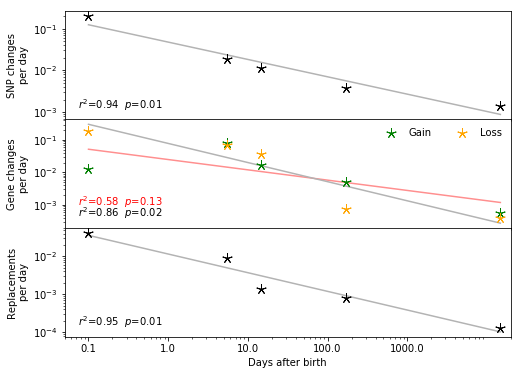

In [73]:
# Second version: put gains and losses on same subplot

fig, ax = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

xs = np.array([0.1, 5.4, 14.5, 171, 14750])

ax[0].plot(xs, means, marker=(5, 2), color='black', linestyle='None', markersize=10)
# ax[0].scatter(xs, means, marker='D', color='black', linestyle='None', s=16)
# ax[0].scatter(day1s, rates, alpha=0.6)

m, b = np.polyfit(np.log(xs), np.log(means), deg=1)
r2 = np.corrcoef(np.log(xs), np.log(means))[0, 1]**2
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(xs),np.log(means))
ax[0].plot(xs, np.exp(m*np.log(xs) + b), color='0.7', zorder=-1)
ax[0].text(0.03, 0.1, r'$r^2$=%.02f  $\it{p}$=%.02f' % (r2, p_value), transform=ax[0].transAxes)
# ax[0].text(0.8, 0.55, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f\np: %.02f" % (m, b, r2, p_value), transform=ax[0].transAxes)

ax[0].set_yscale('log')
ax[0].set_xscale('log')

ax[0].set_ylabel("SNP changes\nper day")

# ================================================================================

legend_elements = [Patch(facecolor='#b3de69', label='Gain'), Patch(facecolor='#ff7f00', label='Loss')]

ax[1].plot(xs, gain_means, marker=(5, 2), color='green', linestyle='None', markersize=10, zorder=5, label='Gain')
# gainr_all = ax[1].scatter(xs, gain_means, marker='^', color='green', linestyle='None', s=16, zorder=5, label='Gain')
# gainr_means = ax[1].scatter(gain_day1s, gain_rates, color='#b3de69', alpha=0.6, label='Gain')

m, b = np.polyfit(np.log(xs), np.log(gain_means), deg=1)
r2 = np.corrcoef(np.log(xs), np.log(gain_means))[0, 1]**2
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(xs),np.log(gain_means))
ax[1].plot(xs, np.exp(m*np.log(xs) + b), color='red', alpha=0.44, zorder=-2)
ax[1].text(0.03, 0.2, r'$r^2$=%.02f  $\it{p}$=%.02f' % (r2, p_value), transform=ax[1].transAxes, color='red')
# ax[1].text(0.8, 0.55, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f\np: %.02f" % (m, b, r2, p_value), transform=ax[1].transAxes, color='red')

ax[1].plot(xs, loss_means, marker=(5, 2), color='orange', linestyle='None', markersize=10, zorder=6, label='Loss')
# lossr_all = ax[1].scatter(xs, loss_means, marker='v', color='orange', linestyle='None', s=16, zorder=6, label='Loss')
# lossr_means = ax[1].scatter(loss_day1s, loss_rates, color='#ff7f00', alpha=0.6, zorder=5, label='Loss')

m, b = np.polyfit(np.log(xs), np.log(loss_means), deg=1)
r2 = np.corrcoef(np.log(xs), np.log(loss_means))[0, 1]**2
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(xs),np.log(loss_means))
ax[1].plot(xs, np.exp(m*np.log(xs) + b), color='0.7', zorder=-1)
ax[1].text(0.03, 0.1, r'$r^2$=%.02f  $\it{p}$=%.02f' % (r2, p_value), transform=ax[1].transAxes)
# ax[1].text(0.8, 0.55, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f\np: %.02f" % (m, b, r2, p_value), transform=ax[1].transAxes)

ax[1].set_yscale('log')
ax[1].set_xscale('log')

ax[1].legend(frameon=False, ncol=2)
# ax[1].legend([(gainr_means, gainr_all), (lossr_means, lossr_all)], ["Gain", "Loss"], frameon=False, ncol=2)

ax[1].set_ylabel("Gene changes\nper day")

# ================================================================================
replace_means = replacement_rate_annotations

ax[2].plot(xs, replace_means, marker=(5, 2), color='black', linestyle='None', markersize=10)
# ax[2].scatter(xs, replace_means, marker='D', color='black', linestyle='None', s=16)

m, b = np.polyfit(np.log(xs), np.log(replace_means), deg=1)
r2 = np.corrcoef(np.log(xs), np.log(replace_means))[0, 1]**2
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(xs),np.log(replace_means))
ax[2].plot(xs, np.exp(m*np.log(xs) + b), color='0.7', zorder=-1)
ax[2].text(0.03, 0.1, r'$r^2$=%.02f  $\it{p}$=%.02f' % (r2, p_value), transform=ax[2].transAxes)
# ax[2].text(0.8, 0.55, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f\np: %.02f" % (m, b, r2, p_value), transform=ax[2].transAxes)

ax[2].set_yscale('log')

ax[2].set_xlabel("Days after birth")
ax[2].set_ylabel("Replacements\nper day")

ax[2].set_xlim((0.05, 20000))
ax[2].set_xticks([0.1, 1, 10, 100, 1000])
ax[2].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.subplots_adjust(hspace=0)
plt.show()

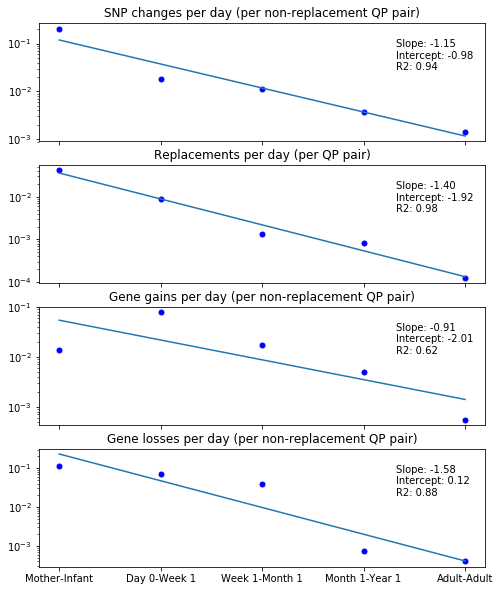

In [32]:
# Linear regression

# Combined SNP change, replacement, gene gain and loss rate plot: final version??

fig, ax = plt.subplots(4, 1, figsize=(8, 10), sharex=True)

tp_types = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'Adult-Adult']

xs = np.arange(1, 1+len(tp_types))

ax[0].plot(xs, snp_change_rate_annotations, '.b', linestyle='None', markersize=10)
ax[0].set_yscale('log')
m, b = np.polyfit(xs, np.log(snp_change_rate_annotations), deg=1)
r2 = np.corrcoef(xs, np.log(snp_change_rate_annotations))[0, 1]**2
ax[0].plot(xs, np.exp(m*xs + b))
ax[0].text(0.8, 0.6, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f" % (m, b, r2), transform=ax[0].transAxes)
ax[0].set_title("SNP changes per day (per non-replacement QP pair)")

ax[1].plot(xs, replacement_rate_annotations, '.b', linestyle='None', markersize=10)
ax[1].set_yscale('log')
m, b = np.polyfit(xs, np.log(replacement_rate_annotations), deg=1)
r2 = np.corrcoef(xs, np.log(replacement_rate_annotations))[0, 1]**2
ax[1].plot(xs, np.exp(m*xs + b))
ax[1].text(0.8, 0.6, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f" % (m, b, r2), transform=ax[1].transAxes)
ax[1].set_title("Replacements per day (per QP pair)")

ax[2].plot(xs, gain_annotations, '.b', linestyle='None', markersize=10)
ax[2].set_yscale('log')
m, b = np.polyfit(xs, np.log(gain_annotations), deg=1)
r2 = np.corrcoef(xs, np.log(gain_annotations))[0, 1]**2
ax[2].plot(xs, np.exp(m*xs + b))
ax[2].text(0.8, 0.6, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f" % (m, b, r2), transform=ax[2].transAxes)
ax[2].set_title("Gene gains per day (per non-replacement QP pair)")

ax[3].plot(xs, loss_annotations, '.b', linestyle='None', markersize=10)
ax[3].set_yscale('log')
m, b = np.polyfit(xs, np.log(loss_annotations), deg=1)
r2 = np.corrcoef(xs, np.log(loss_annotations))[0, 1]**2
ax[3].plot(xs, np.exp(m*xs + b))
ax[3].text(0.8, 0.6, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f" % (m, b, r2), transform=ax[3].transAxes)
ax[3].set_title("Gene losses per day (per non-replacement QP pair)")
ax[3].set_xticks(xs)
ax[3].set_xticklabels(tp_types)

plt.show()

In [57]:
# Statistics for plot
for tp_type, rate in zip(tp_types, replacement_rate_annotations):
    print("Rate for %s: %.2E" % (tp_type, rate))

Rate for Mother-Infant: 4.17E-02
Rate for Day 0-Week 1: 8.86E-03
Rate for Week 1-Month 1: 1.36E-03
Rate for Month 1-Year 1: 8.11E-04
Rate for Adult-Adult: 1.26E-04


In [98]:
# Store gene change information

tp_types = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'Adult-Adult']

num_gain_by_species_tp_type = {tt: defaultdict(int) for tt in tp_types}
num_loss_by_species_tp_type = {tt: defaultdict(int) for tt in tp_types}

for species in gene_changes:
    for s1, s2 in gene_changes[species]:
        
        gains, losses = gene_changes[species][(s1, s2)]
        custom_cohorts = custom_cohorts_of_sample_pair(custom_cohort_tests, s1, s2, species)
        days = sample_pair_to_days(s1, s2)
        
        # Skip negative days for now (seems to be either Yassour 3rd mom tp, Ferretti reverse IM)
        if days < 0:
            continue
        
        if isinstance(snp_changes[species][(s1, s2)], int): # Replacement (in terms of SNP changes)
            pass
            # num_gains, num_losses = gene_changes[species][(s1, s2)]
        else:
            num_gains = len(gene_changes[species][(s1, s2)][0])
            num_losses = len(gene_changes[species][(s1, s2)][1])
        
        for custom_cohort in custom_cohorts:
            num_gain_by_species_tp_type[custom_cohort][species] += num_gains
            num_loss_by_species_tp_type[custom_cohort][species] += num_losses

In [ ]:
'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1'

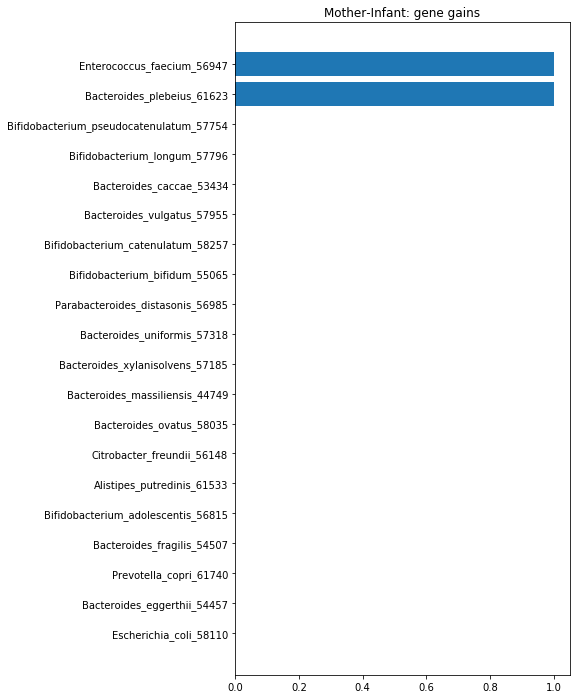

In [103]:
custom_cohort = 'Mother-Infant'
fig, ax = plt.subplots(figsize=(6, 12))
species_count_dict = num_gain_by_species_tp_type[custom_cohort]
species_count_tups_sorted = sorted(species_count_dict.items(), key=lambda x: x[1])
counts = [x[1] for x in species_count_tups_sorted]
species = [x[0] for x in species_count_tups_sorted]
ys = np.arange(len(species))
ax.barh(species, counts)
ax.set_title(custom_cohort + ": gene gains")
plt.show()

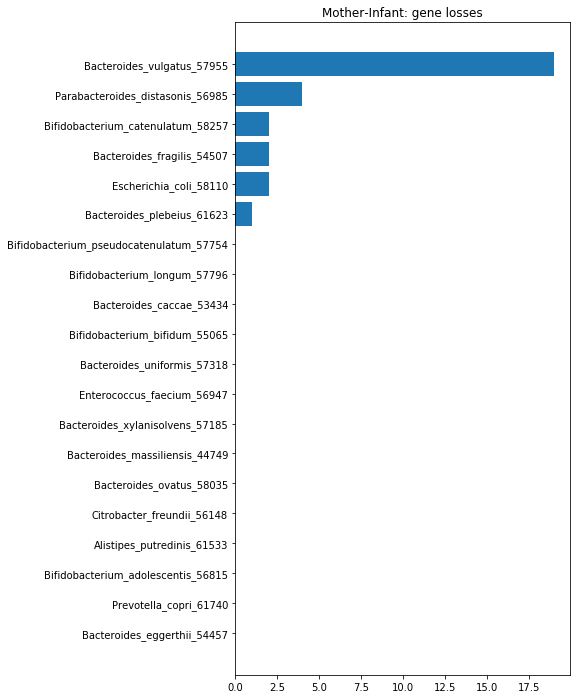

In [104]:
custom_cohort = 'Mother-Infant'
fig, ax = plt.subplots(figsize=(6, 12))
species_count_dict = num_loss_by_species_tp_type[custom_cohort]
species_count_tups_sorted = sorted(species_count_dict.items(), key=lambda x: x[1])
counts = [x[1] for x in species_count_tups_sorted]
species = [x[0] for x in species_count_tups_sorted]
ys = np.arange(len(species))
ax.barh(species, counts)
ax.set_title(custom_cohort + ": gene losses")
plt.show()

In [96]:
sample_species_qp_dict = pickle.load(open("%s/pickles/sample_species_qp_dict.pkl" % config.data_directory, 'rb'))

In [92]:
total_infant_lowcov_samples = 0
total_infant_highcov_samples = 0
total_infant_qp_samples = 0

for sample in sample_species_qp_dict['infant']:
    
    # Skip  Olm
    if sample not in infant_samples:
        continue
    
    for species in sample_species_qp_dict['infant'][sample]:
        status = sample_species_qp_dict['infant'][sample][species]
        if status == 'low-coverage':
            total_infant_lowcov_samples += 1
        else:
            total_infant_highcov_samples += 1
        if status == 'qp':
            total_infant_qp_samples += 1

In [93]:
print(total_infant_qp_samples)

7063


In [94]:
total_mother_lowcov_samples = 0
total_mother_highcov_samples = 0
total_mother_qp_samples = 0

for sample in sample_species_qp_dict['mother']:
    
    # Skip  Olm
    if sample not in mother_samples:
        continue
    
    for species in sample_species_qp_dict['mother'][sample]:
        status = sample_species_qp_dict['mother'][sample][species]
        if status == 'low-coverage':
            total_mother_lowcov_samples += 1
        else:
            total_mother_highcov_samples += 1
        if status == 'qp':
            total_mother_qp_samples += 1

In [95]:
print(total_mother_highcov_samples)

1956


In [97]:
sample_species_qp_dict['hmp']

defaultdict(dict,
            {'700013588': {'Acidaminococcus_intestini_54097': 'low-coverage',
              'Actinomyces_sp_62581': 'low-coverage',
              'Actinomyces_urogenitalis_53864': 'low-coverage',
              'Akkermansia_muciniphila_55290': 'qp',
              'Alistipes_finegoldii_56071': 'low-coverage',
              'Alistipes_indistinctus_62207': 'low-coverage',
              'Alistipes_onderdonkii_55464': 'low-coverage',
              'Alistipes_putredinis_61533': 'low-coverage',
              'Alistipes_shahii_62199': 'low-coverage',
              'Alistipes_sp_59510': 'low-coverage',
              'Alistipes_sp_60764': 'qp',
              'Anaerococcus_obesiensis_58051': 'low-coverage',
              'Anaerostipes_hadrus_55206': 'low-coverage',
              'Bacteroidales_bacterium_58650': 'low-coverage',
              'Bacteroides_acidifaciens_59693': 'low-coverage',
              'Bacteroides_caccae_53434': 'qp',
              'Bacteroides_cellulosilyticus